<a href="https://colab.research.google.com/github/PierluigiManc01/Thesis/blob/main/tesi_minute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction with LSTM and Transformer Models

In [ ]:
import math
import time
import io
import numpy as np
import csv
import pandas as pd
import os
from datetime import datetime
import random
# visuals package
import matplotlib.pyplot as plt
import seaborn as sns
# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Torchtest package
import torchtext
from torchtext import datasets
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
#Sklearn package
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_recall_fscore_support, classification_report, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, TimeSeriesSplit

#Tensorflow - Keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Softmax, Multiply, Permute, Flatten, Activation, Input, Attention, Bidirectional
from tensorflow.keras.models import Model

#cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set torch seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the random seed for other libraries
random.seed(seed)
np.random.seed(seed)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.2 MB/s eta 0:00:00


## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Utils

In [ ]:
def oversample(X,y, oversampling_ratio = 0.8, maj_class = 2, min_class = (1,2)):
  oversampling_ratio = oversampling_ratio

  # Compute the number of synthetic samples to be generated based on the desired ratio and the size of the minority class
  max_class_count = np.sum(y == maj_class)
  print(max_class_count)
  desired_samples = int(max_class_count * oversampling_ratio)

  smote = SMOTE(sampling_strategy={i: desired_samples for i in min_class})
 # smote = SMOTE(sampling_strategy={min_class[i]: desired_samples[i] for i in min})

  # Step 4: Apply SMOTE to the minority class

  X_resampled, y_resampled = smote.fit_resample(X, y)

  # Step 5: (Optional) Check the class distribution
  unique, counts = np.unique(y_resampled, return_counts=True)
  print("Resampled class distribution",dict(zip(unique, counts)))
  return X_resampled, y_resampled

In [ ]:
def new_chg(data_chg):
  data_chg = data_chg.str.rstrip('%')
  data_chg = data_chg.astype(float)
  data_chg.fillna(0, inplace = True)
  return data_chg

def new_net(data_nett):
  data_nett.fillna(0, inplace = False)
  return data_nett

def obj_to_float(col):
  col = col.replace(',', '', regex=True)
  col = col.astype(float)
  return col
def obj_to_float2(col):
    for idx in range(len(col)):
        object_value = col[idx]
        if object_value == None :
            try:
                # Get the neighboring values
                prev_value = float(col[idx - 1]) if (idx - 1 >= 0 and col[idx - 1] != None) else None
                next_value = float(col[idx + 1]) if (idx + 1 < len(col) and col[idx + 1] != None) else None
                neighbors = [v for v in [prev_value, next_value] if v is not None]
                float_value = sum(neighbors) / len(neighbors) if neighbors else None

                # Replace the current value with the computed float value
                col.iloc[idx] = float_value
            except ValueError:
                print(f"Could not convert '{object_value}' to float")
                # Handle error as needed

    col = col.astype(float)
    return col
def new_date(data_date):
  data_date = data_date.replace("-","/")
  data_date = pd.to_datetime(data_date)
  return data_date

def new_time(data_time):
  data_time  = pd.to_datetime(data_time.astype(str),format = "%H:%M").dt.time
  return data_time


In [ ]:
def remove_redundant():
  start_time = datetime.strptime("22:02", '%H:%M').time()
  end_time = datetime.strptime("15:29", '%H:%M').time()

  return data[(data['Local Time'] < start_time) & (data['Local Time'] > end_time)]


In [ ]:
def build_target(column):
  target = []
  for change in column:
    if change >= 0.5 * column.std() :
      target.append(2)
    elif change <= -0.5 * column.std() :
      target.append(1)
    else:
      target.append(0)
  return target


In [ ]:
def define_class_weights(data):
  grows, decrease, same = 0,0,0
  for value in data:
    if value == 2:
      grows += 1
    elif value == 1:
      decrease += 1
    else:
      same += 1
  class_labels = ["Hold",'Sell', 'Buy']
  plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
  plt.title("Class Distribution")
  plt.legend()

  n = len(data)
  class_weight = [same/n, decrease/n, grows/n]
  weight_tensor = loss_weights_light_keras(class_weight)

  for i , val in enumerate(weight_tensor) :
    print("class",i,"is weighted",val)
  return weight_tensor

def calculate_class_weights(data):
  total = len(data)
  class_w = {
  0: total / (2 * np.sum(data == 0)),
  1: total / (3 * np.sum(data == 1)),
  2: total / (3 * np.sum(data == 2))}
  return class_w

In [ ]:
# Calculate Williams %R
def calculate_williams_percent_r(high, low, close, period):
    highest_high = high.rolling(window=period).max()
    lowest_low = low.rolling(window=period).min()
    williams_percent_r = (highest_high - close) / (highest_high - lowest_low) * -100
    return williams_percent_r

def calculate_rsi(data, window):
    close_prices = data['Close']
    delta = close_prices.diff().dropna()
    # Calculate gains and losses
    gains = delta.copy()
    losses = delta.copy()
    gains[gains < 0] = 0
    losses[losses > 0] = 0
    # Calculate average gains and losses
    avg_gains = gains.rolling(window).mean()
    avg_losses = losses.rolling(window).mean()
    # Calculate relative strength (RS)
    rs = abs(avg_gains / avg_losses)
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_ema(data, window):
    close_prices = data['Close']
    ema = close_prices.ewm(span=window, adjust=False).mean()
    return ema

In [ ]:
def normalize(x):
    x = (x - x.min(axis = 0))/(x.max(axis = 0) - x.min(axis = 0))
    return x


In [ ]:
from sklearn.model_selection import train_test_split
def train_test_split_fun(x,y,size = 0.1, stratify = True):
  if stratify:
    #y_train_encoded = pd.get_dummies(y)
    strat = y
  x_train, X_test, Y_train, y_test = train_test_split(x,y, train_size=size, stratify = strat )
  test = np.hstack((X_test,y_test))
  # Now since we want the valid and test size to be equal (10% each of overall data).
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  X_train, X_valid, y_train, y_valid = train_test_split(x_train,Y_train, test_size= size, stratify = strat )
  train = np.hstack((X_train, y_train))
  valid = np.hstack((X_valid, y_valid))
  return train, valid, test

In [ ]:
def train_val_test(data,size):
  train_size = int(len(data)*size)
  test_coef = 0.5 #fraction of the remaining dataset to retain for the test set
  val_size = int((len(data) - train_size)*test_coef) + train_size
  train, val, test = data[:train_size, :], data[train_size:val_size, :], data[val_size:, : ]
  return train, val, test

def train_val_test_k(data,size,val_coef = 0.5):
  train_size = int(len(data)*size)
  coef = val_coef #fraction of the remaining dataset to retain for the test set
  val_size = int((len(data) - train_size)*coef) + train_size
  train, val, test = data.iloc[:train_size, :], data.iloc[train_size:val_size, :], data.iloc[val_size:, : ]
  return train, val, test

In [ ]:
def generate_dataset(data, lookback):
  """ This function is used to convert a timeseries dataset into a  prediction dataset
    Arguments:
              data: time series set
              lookback: time window length for predicions
"""
  x, y = [], []
  for i in range(len(data)-lookback):
    features = data[i:i+lookback, :-1]
    target = data[i+lookback, -1]
    x.append(features)
    y.append(target)
  return torch.tensor(np.array(x)),torch.tensor(np.array(y))

def generate_keras_dataset(data, lookback):
  """ This function is used to convert a timeseries dataset into a  prediction dataset
    Arguments:
              data: time series set
              lookback: time window length for predicions
"""
  x, y = [], []
  for i in range(len(data)-lookback):
    features = data.iloc[i:i+lookback, :-1]
    target = data.iloc[i+lookback, -1]
    x.append(features)
    y.append(target)
  return np.array(x),np.array(y)

In [ ]:
def boxplot(data):
  column_names = data.columns.tolist()
  data = data.values.astype("float64")
  fig, axes = plt.subplots(nrows=1, ncols=data.shape[1], figsize=(18, 8))

# Iterate over each feature and create a boxplot
  for i, ax in enumerate(axes):
      ax.boxplot(data[:, i])
      ax.set_xlabel('Feature {}'.format(i+1))
      ax.set_ylabel('Dollars')
      ax.set_title('Boxplot of {}'.format(column_names[i]))
  plt.tight_layout()

  # Display the plot
  plt.show()

In [ ]:
def loss_weights(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = torch.tensor(majority_class/np.array(weights))
  w = w + (w != 1.0).float()
  w = torch.ceil(w)
  return w

def loss_weights_light(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = torch.tensor(majority_class/np.array(weights))
  w = w - (w != 1.0).float()
  return w


def loss_weights_keras(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = np.array(majority_class/np.array(weights))
  #w = w + (w != 1.0).float()
  w = np.ceil(w)
  return w

def loss_weights_light_keras(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = np.array(majority_class/np.array(weights))
  return w

## Model Implementation

#### LSTM


 The following equations describe LSTM 's architecture:
\begin{array}{ll} \\
    i_t = \sigma(x_t.W_{ii}  + b_{ii} +  h_{t-1}.W_{hi} + b_{hi}) \\
    f_t = \sigma(x_t.W_{if} + b_{if} +  h_{t-1}.W_{hf} + b_{hf}) \\
    g_t = \tanh(x_t.W_{ig} + b_{ig} +  h_{t-1}.W_{hg} + b_{hg}) \\
    o_t = \sigma( x_t.W_{io} + b_{io} +  h_{t-1}.W_{ho} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

However, thanks to nn.Module, all this is already implemented by simply importing the library.

In [ ]:
from tensorflow.keras.regularizers import l2

def create_keras_model(inp_size=2, hidden_size=64, output_size=3, dropout_rate=0.1, num_layers=5, l2_rate = 0.01):
    model = Sequential()
    for _ in range(num_layers - 2):
        model.add(LSTM(hidden_size, input_shape=(None, inp_size), return_sequences=True, kernel_regularizer=l2(l2_rate)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(hidden_size, return_sequences=False, kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32,activation = "relu", kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(0.2))

    model.add(Dense(output_size, kernel_regularizer=l2(l2_rate)))
    model.add(Softmax(axis=-1))

    return model

#### Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## Model Implementation DAILY

#### LSTM


 The following equations describe LSTM 's architecture:
\begin{array}{ll} \\
    i_t = \sigma(x_t.W_{ii}  + b_{ii} +  h_{t-1}.W_{hi} + b_{hi}) \\
    f_t = \sigma(x_t.W_{if} + b_{if} +  h_{t-1}.W_{hf} + b_{hf}) \\
    g_t = \tanh(x_t.W_{ig} + b_{ig} +  h_{t-1}.W_{hg} + b_{hg}) \\
    o_t = \sigma( x_t.W_{io} + b_{io} +  h_{t-1}.W_{ho} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

However, thanks to nn.Module, all this is already implemented by simply importing the library.

In [ ]:
from tensorflow.keras.regularizers import l2

def create_keras_model(inp_size=2, hidden_size=64, output_size=3, dropout_rate=0.1, num_layers=5,l2_rate = 0.01):
    model = Sequential()
    for _ in range(num_layers - 2):
        model.add(LSTM(hidden_size, input_shape=(None, inp_size), return_sequences=True, kernel_regularizer=l2(l2_rate)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(hidden_size, return_sequences=False, kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32,activation = "relu", kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(0.2))

    model.add(Dense(output_size, kernel_regularizer=l2(l2_rate)))
    model.add(Softmax(axis=-1))

    return model

#### AttentionLSTM

In [ ]:
def build_attention_model(input_shape, hidden_size, num_layers, dropout_rate, l2_rate):
    inputs = Input(shape=input_shape)
    lstm_out, forward_h, backward_h, forward_c, backward_c = Bidirectional(
        LSTM(hidden_size, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_rate))
    )(inputs)

    lstm_out = Dropout(dropout_rate)(lstm_out)

    for _ in range(num_layers - 1):
        # LSTM layer
        lstm_out, forward_h, backward_h, forward_c, backward_c = Bidirectional(
            LSTM(hidden_size, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_rate))
        )(lstm_out)
        #lstm_out = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True))(lstm_out)
        lstm_out = Dropout(dropout_rate)(lstm_out)

    # Attention layer
    attention = Attention()([lstm_out, lstm_out])

    # Flatten layer to prepare the output of the attention layer for the Dense layer
    flat = Flatten()(attention)

    # Dense (output) layer
    outputs = Dense(3, activation='softmax', kernel_regularizer=l2(l2_rate))(flat)

    att_model = Model(inputs=inputs, outputs=outputs)
    return att_model

#### Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0,l2_rate = 0.05):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", kernel_regularizer=l2(l2_rate))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, kernel_regularizer=l2(l2_rate))(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    l2_rate = 0.05
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_rate)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def build_model2(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    dropout=0,
    l2_rate = 0.05
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_rate)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    outputs = layers.Dense(3, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# APPLE min analysis

### Read the data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TESI/csv data/stock/AAPL_min.csv")

In [ ]:
data

Local Date Local Time   Close   Net    %Chg    Open     Low    High  \
0      08-Jun-2023      23:59  180.48  0.01  +0.01%  180.47  180.47  180.50   
1      08-Jun-2023      23:58  180.47 -0.02  -0.01%  180.50  180.47  180.50   
2      08-Jun-2023      23:57  180.49  0.01  +0.00%  180.49  180.47  180.50   
3      08-Jun-2023      23:56  180.48 -0.01  -0.01%  180.49  180.48  180.50   
4      08-Jun-2023      23:55  180.49  0.00   0.00%  180.49  180.48  180.50   
...            ...        ...     ...   ...     ...     ...     ...     ...   
43195  04-Apr-2023      20:28  165.83 -0.05  -0.03%  165.87  165.78  165.92   
43196  04-Apr-2023      20:27  165.87 -0.03  -0.02%  165.90  165.83  165.92   
43197  04-Apr-2023      20:26  165.90  0.02  +0.01%  165.88  165.88  165.96   
43198  04-Apr-2023      20:25  165.88 -0.07  -0.04%  165.96  165.83  165.97   
43199  04-Apr-2023      20:24  165.95   NaN     NaN  166.00  165.95  166.03   

       Volume  
0         268  
1          48  
2         352  
3         264  
4         375  
...       ...  
43195  74,052  
43196  34,258  
43197  55,923  
43198  79,486  
43199  64,471  

[43200 rows x 9 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local Date  43200 non-null  object 
 1   Local Time  43200 non-null  object 
 2   Close       42855 non-null  float64
 3   Net         42854 non-null  float64
 4   %Chg        42854 non-null  object 
 5   Open        42855 non-null  float64
 6   Low         42855 non-null  float64
 7   High        42855 non-null  float64
 8   Volume      42855 non-null  object 
dtypes: float64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
data = data.sort_index(ascending=False)
data.reset_index(drop = True, inplace=True)
data

Local Date Local Time   Close   Net    %Chg    Open     Low    High  \
0      04-Apr-2023      20:24  165.95   NaN     NaN  166.00  165.95  166.03   
1      04-Apr-2023      20:25  165.88 -0.07  -0.04%  165.96  165.83  165.97   
2      04-Apr-2023      20:26  165.90  0.02  +0.01%  165.88  165.88  165.96   
3      04-Apr-2023      20:27  165.87 -0.03  -0.02%  165.90  165.83  165.92   
4      04-Apr-2023      20:28  165.83 -0.05  -0.03%  165.87  165.78  165.92   
...            ...        ...     ...   ...     ...     ...     ...     ...   
43195  08-Jun-2023      23:55  180.49  0.00   0.00%  180.49  180.48  180.50   
43196  08-Jun-2023      23:56  180.48 -0.01  -0.01%  180.49  180.48  180.50   
43197  08-Jun-2023      23:57  180.49  0.01  +0.00%  180.49  180.47  180.50   
43198  08-Jun-2023      23:58  180.47 -0.02  -0.01%  180.50  180.47  180.50   
43199  08-Jun-2023      23:59  180.48  0.01  +0.01%  180.47  180.47  180.50   

       Volume  
0      64,471  
1      79,486  
2      55,923  
3      34,258  
4      74,052  
...       ...  
43195     375  
43196     264  
43197     352  
43198      48  
43199     268  

[43200 rows x 9 columns]

###Data Preprocessing

Now I combine Date and Time into DateTime for graphic purposes.


In [ ]:
data["DateTime"] = pd.to_datetime(data["Local Date"] + ' ' +  data["Local Time"])

Clean the data to have the correct field types and filling missing values.

In [ ]:
data["%Chg"] = new_chg(data["%Chg"])
data["Volume"] = obj_to_float(data["Volume"])
data['Local Date'] = new_date(data['Local Date'])
data["Local Time"] = new_time(data["Local Time"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Local Date  43200 non-null  datetime64[ns]
 1   Local Time  43200 non-null  object        
 2   Close       42855 non-null  float64       
 3   Net         42854 non-null  float64       
 4   %Chg        43200 non-null  float64       
 5   Open        42855 non-null  float64       
 6   Low         42855 non-null  float64       
 7   High        42855 non-null  float64       
 8   Volume      42855 non-null  float64       
 9   DateTime    43200 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(1)
memory usage: 3.3+ MB


 We need to realize that there are too many datapoints because date and time do not account for hours in which the market is closed and prices do not move. Therefore, we need to remove redundant times.

In [ ]:
## Removes the redundant hours, keeping the market working hours only. Being the US market, it
## corresponds to 15.30-22.01 in Italy.
data = remove_redundant()
data.reset_index(drop=True, inplace=True)

In [ ]:
data["Net"].fillna(0.0, inplace = True)

<ipython-input-67-cdfe86fd7658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Net"].fillna(0.0, inplace = True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17738 entries, 0 to 17737
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Local Date  17738 non-null  datetime64[ns]
 1   Local Time  17738 non-null  object        
 2   Close       17738 non-null  float64       
 3   Net         17738 non-null  float64       
 4   %Chg        17738 non-null  float64       
 5   Open        17738 non-null  float64       
 6   Low         17738 non-null  float64       
 7   High        17738 non-null  float64       
 8   Volume      17738 non-null  float64       
 9   DateTime    17738 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(1)
memory usage: 1.4+ MB


In [ ]:
data = data.dropna()

#### Feature Engineering

In [ ]:
period = 14
# moving average
data['MA'] = data['Close'].copy().rolling(window=period).mean()

# Calculate standard deviation
data['std_dev'] = data['Close'].copy().rolling(window=period).std()

# Calculate Williams %R

data['williams_percent_r'] = calculate_williams_percent_r(data['High'], data['Low'], data['Close'], period)
# exponential moving average
data["EMA"] = calculate_ema(data,period)
# residual strength index
data["RSI"] = calculate_rsi(data,period)
data.fillna(data.mean(), inplace = True)
data['SMA_Net'] = data['Net'].rolling(window=14).mean()
data['EMA_Net'] = data['Net'].ewm(span=14, adjust=False).mean()
data['std_dev_Net'] = data['Net'].rolling(window=14).std()


<ipython-input-70-daa2bc8b5778>:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace = True)
<ipython-input-70-daa2bc8b5778>:15: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace = True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17738 entries, 0 to 17737
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Local Date          17738 non-null  datetime64[ns]
 1   Local Time          17738 non-null  object        
 2   Close               17738 non-null  float64       
 3   Net                 17738 non-null  float64       
 4   %Chg                17738 non-null  float64       
 5   Open                17738 non-null  float64       
 6   Low                 17738 non-null  float64       
 7   High                17738 non-null  float64       
 8   Volume              17738 non-null  float64       
 9   DateTime            17738 non-null  datetime64[ns]
 10  MA                  17738 non-null  float64       
 11  std_dev             17738 non-null  float64       
 12  williams_percent_r  17738 non-null  float64       
 13  EMA                 17738 non-null  float64   

In [ ]:
data.dropna(inplace=True)

In [ ]:
max_value = data['Volume'].max()
data['Volume'] = data['Volume'].replace(max_value, data['Volume'].where(data['Volume'] != max_value).max())

### Create Target

#### Set the multi-class target. It consists in either a price stays the same (0) or decrease more than 0.5 std (1) or increase more than 0.5 std (2).

In [ ]:
data["Trend"] = build_target(data["Net"])

#### Target

class 0 is weighted 1.0
class 1 is weighted 3.0
class 2 is weighted 3.0


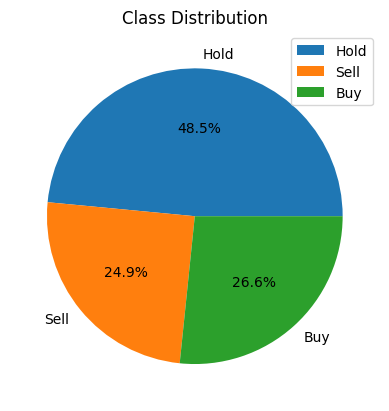

In [ ]:
tgt = data["Trend"]
grows, decrease, same = 0,0,0
for value in tgt:
  if value == 2:
    grows += 1
  elif value == 1:
    decrease += 1
  else:
    same += 1
class_labels = ["Hold",'Sell', 'Buy']
plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
plt.title("Class Distribution")
plt.legend()
n = len(tgt)
class_distr = [same/n, decrease/n, grows/n]
weight_tensor = loss_weights(class_distr)
for i , val in enumerate(weight_tensor.numpy()) :
  print("class",i,"is weighted",val)

### Some Visualizations

In [ ]:
data = data.rename(columns = {"Trend": "Investment Decision"})
correlation_matrix = data.corr()
correlation_matrix

<ipython-input-38-06c13a870895>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Close       Net      %Chg      Open       Low  \
Close                1.000000  0.004162  0.004656  0.999877  0.998017   
Net                  0.004162  1.000000  0.997336 -0.011327 -0.004635   
%Chg                 0.004656  0.997336  1.000000 -0.010804 -0.004121   
Open                 0.999877 -0.011327 -0.010804  1.000000  0.998032   
Low                  0.998017 -0.004635 -0.004121  0.998032  1.000000   
High                 0.999644 -0.004167 -0.003639  0.999652  0.997678   
Volume               0.041903 -0.009916 -0.009042  0.042036  0.039343   
MA                   0.999201 -0.010724 -0.010195  0.999311  0.997392   
std_dev              0.065266  0.032607  0.033050  0.064766  0.058704   
williams_percent_r   0.059733  0.368273  0.369558  0.053953  0.052346   
EMA                  0.999427 -0.009582 -0.009057  0.999519  0.997597   
RSI                  0.047848  0.228441  0.229406  0.044261  0.046113   
SMA_Net              0.014561  0.262601  0.261743  0.010469  0.011668   
EMA_Net              0.014710  0.498964  0.497218  0.006947  0.009320   
std_dev_Net          0.146652 -0.036214 -0.034371  0.147187  0.140362   
Investment Decision  0.047945  0.355213  0.357078  0.042417  0.041059   

                         High    Volume        MA   std_dev  \
Close                0.999644  0.041903  0.999201  0.065266   
Net                 -0.004167 -0.009916 -0.010724  0.032607   
%Chg                -0.003639 -0.009042 -0.010195  0.033050   
Open                 0.999652  0.042036  0.999311  0.064766   
Low                  0.997678  0.039343  0.997392  0.058704   
High                 1.000000  0.043693  0.999048  0.069802   
Volume               0.043693  1.000000  0.040667  0.190764   
MA                   0.999048  0.040667  1.000000  0.058895   
std_dev              0.069802  0.190764  0.058895  1.000000   
williams_percent_r   0.053359  0.016481  0.034425 -0.001016   
EMA                  0.999252  0.040865  0.999957  0.059805   
RSI                  0.044706  0.010265  0.021500  0.008567   
SMA_Net              0.010901  0.010833 -0.012292  0.053531   
EMA_Net              0.008305  0.012153 -0.017064  0.068256   
std_dev_Net          0.153050  0.181242  0.149972  0.630433   
Investment Decision  0.047633  0.050660  0.043656  0.142369   

                     williams_percent_r       EMA       RSI   SMA_Net  \
Close                          0.059733  0.999427  0.047848  0.014561   
Net                            0.368273 -0.009582  0.228441  0.262601   
%Chg                           0.369558 -0.009057  0.229406  0.261743   
Open                           0.053953  0.999519  0.044261  0.010469   
Low                            0.052346  0.997597  0.046113  0.011668   
High                           0.053359  0.999252  0.044706  0.010901   
Volume                         0.016481  0.040865  0.010265  0.010833   
MA                             0.034425  0.999957  0.021500 -0.012292   
std_dev                       -0.001016  0.059805  0.008567  0.053531   
williams_percent_r             1.000000  0.038361  0.756848  0.655071   
EMA                            0.038361  1.000000  0.025104 -0.008682   
RSI                            0.756848  0.025104  1.000000  0.837487   
SMA_Net                        0.655071 -0.008682  0.837487  1.000000   
EMA_Net                        0.731132 -0.012611  0.723179  0.857395   
std_dev_Net                   -0.065327  0.149527 -0.105196 -0.107311   
Investment Decision            0.135679  0.043894  0.066364  0.080400   

                      EMA_Net  std_dev_Net  Investment Decision  
Close                0.014710     0.146652             0.047945  
Net                  0.498964    -0.036214             0.355213  
%Chg                 0.497218    -0.034371             0.357078  
Open                 0.006947     0.147187             0.042417  
Low                  0.009320     0.140362             0.041059  
High                 0.008305     0.153050             0.047633  
Volume

<Axes: >

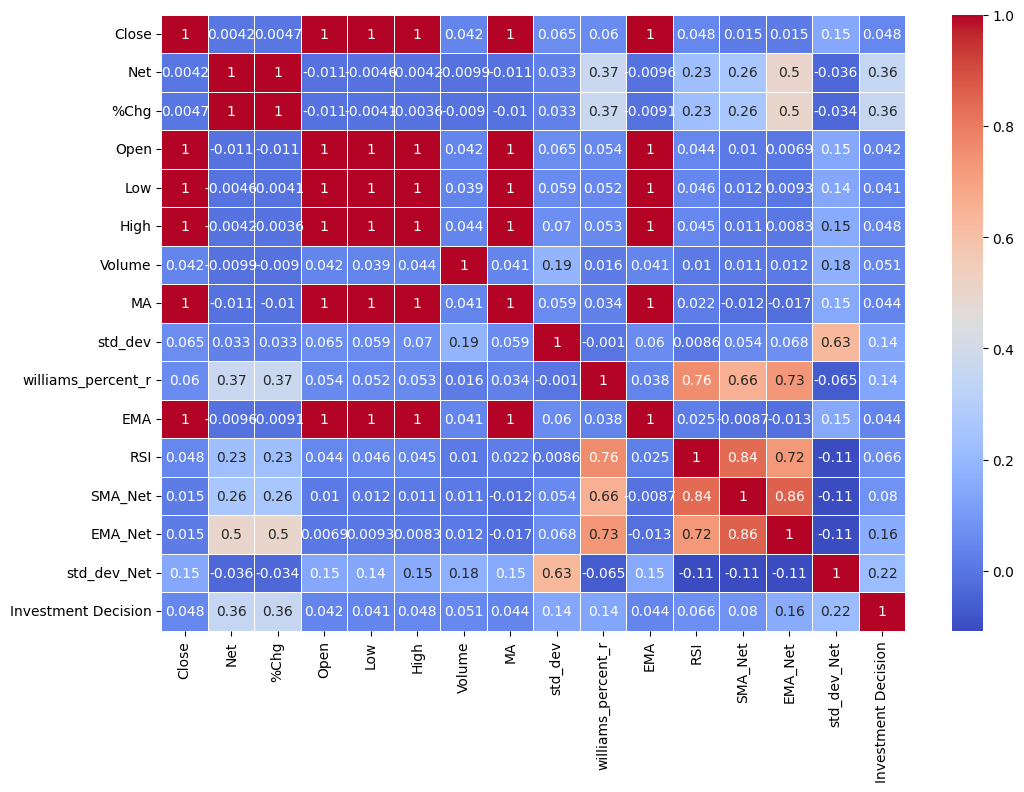

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True ,linewidths=0.5, cmap = "coolwarm")

It is evident how Close, Open, Low, High are actually collinear. Therefore, only one of them can be included in the model to avoid all the multicollinearity issues. For reliability purposes, I stand for choosing "Close". Having noted this, it is also clear that "%Chg" and "Net" are collinear and for the aforementioned reason, I prefer keeping "%Chg". Finally, I have Result which has a high correlation with "%Chg" as it is obtained from it. For this, I keep Result as target variable.

#### Analyse closing prices

In [ ]:
data["Close"].describe()

count    17725.000000
mean       170.615370
std          5.747031
min        159.810000
25%        165.280000
50%        171.520000
75%        174.210000
max        184.940000
Name: Close, dtype: float64

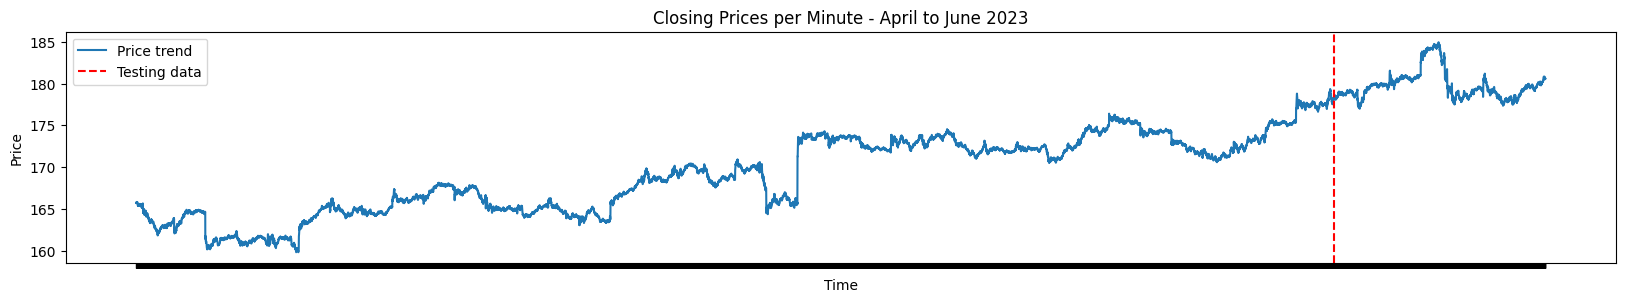

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["DateTime"].astype(str), data["Close"])
plt.xlabel('Time')
plt.ylabel('Price')

plt.axvline(int(len(data["DateTime"])*0.85), color='r', linestyle='--', label='Testing data')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.title('Closing Prices per Minute - April to June 2023')
plt.legend(["Price trend","Testing data"],fontsize="10")

Text(0.5, 1.0, 'Count of closing price values')

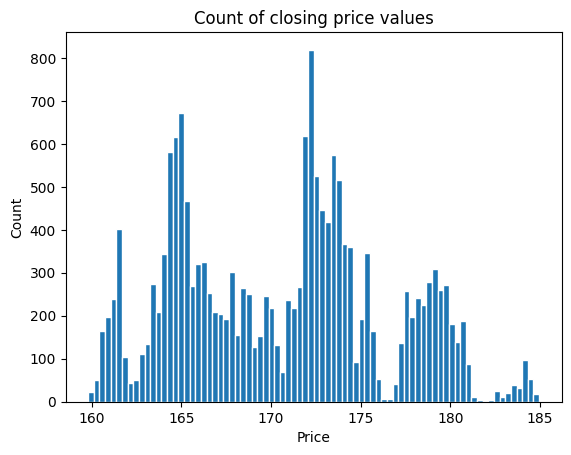

In [ ]:
plt.hist(data["Close"],edgecolor='white', bins = 80)
plt.ylabel("Count")
plt.xlabel("Price")
plt.title("Count of closing price values")

Clearly not normally distributed, they need normalization(applied after splitting training-validation-test sets).

#### Volume

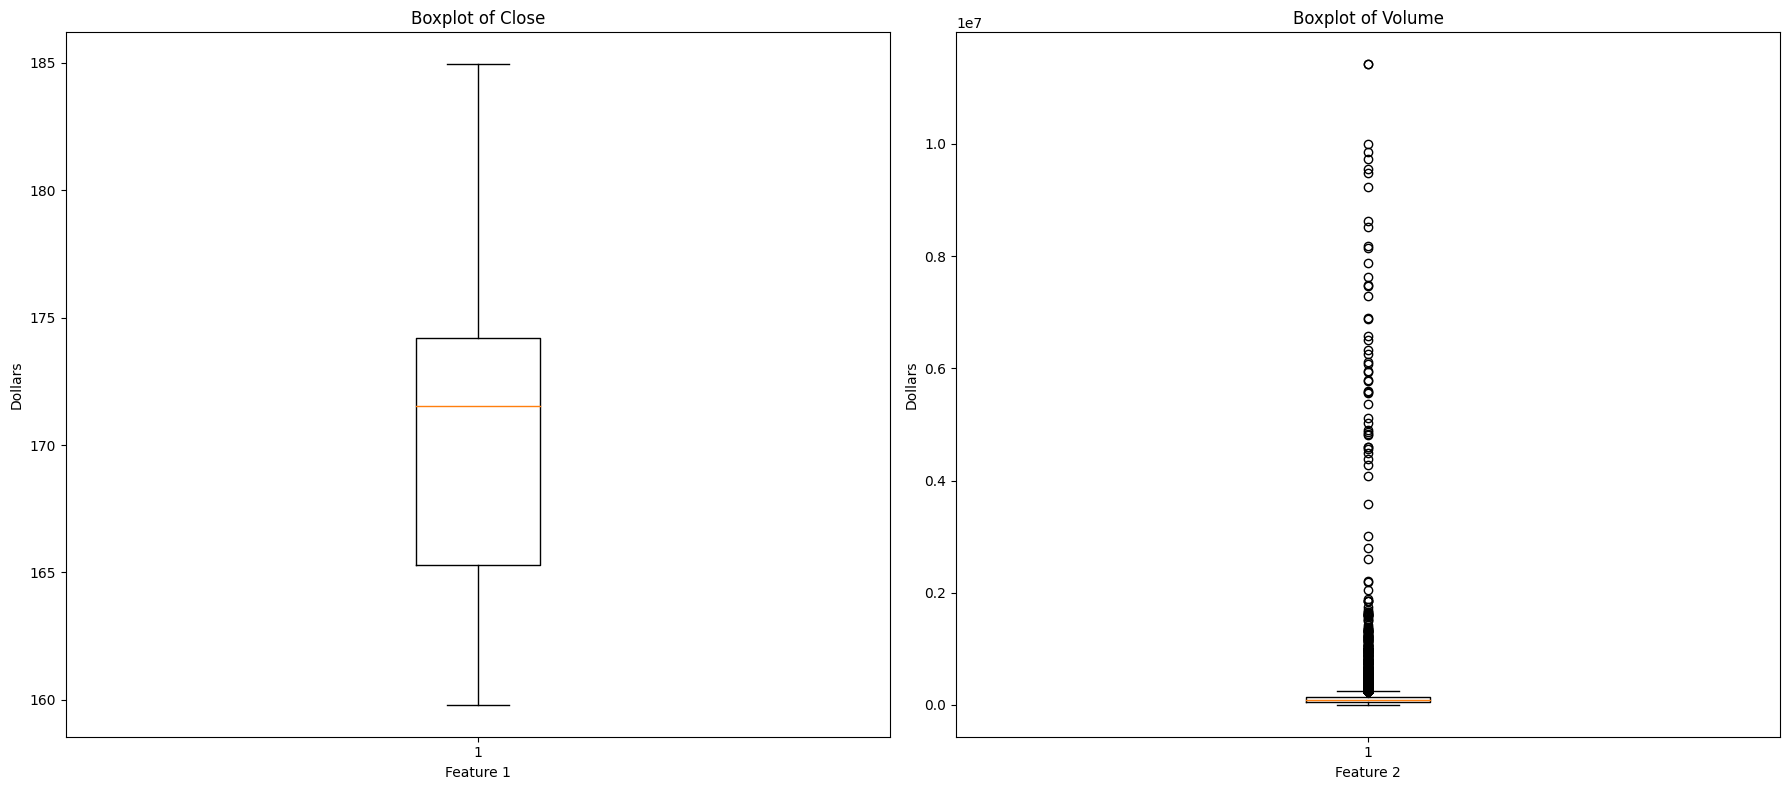

In [ ]:
X_viz = data[["Close", "Volume"]]
boxplot(X_viz)

It is clear that Volume shows exrteme outliers but they are crucial in identifying possible price trends as it represents the level of market activity and liquidity. Therefore, after dropping the very extreme outlier, all the rest is kept.

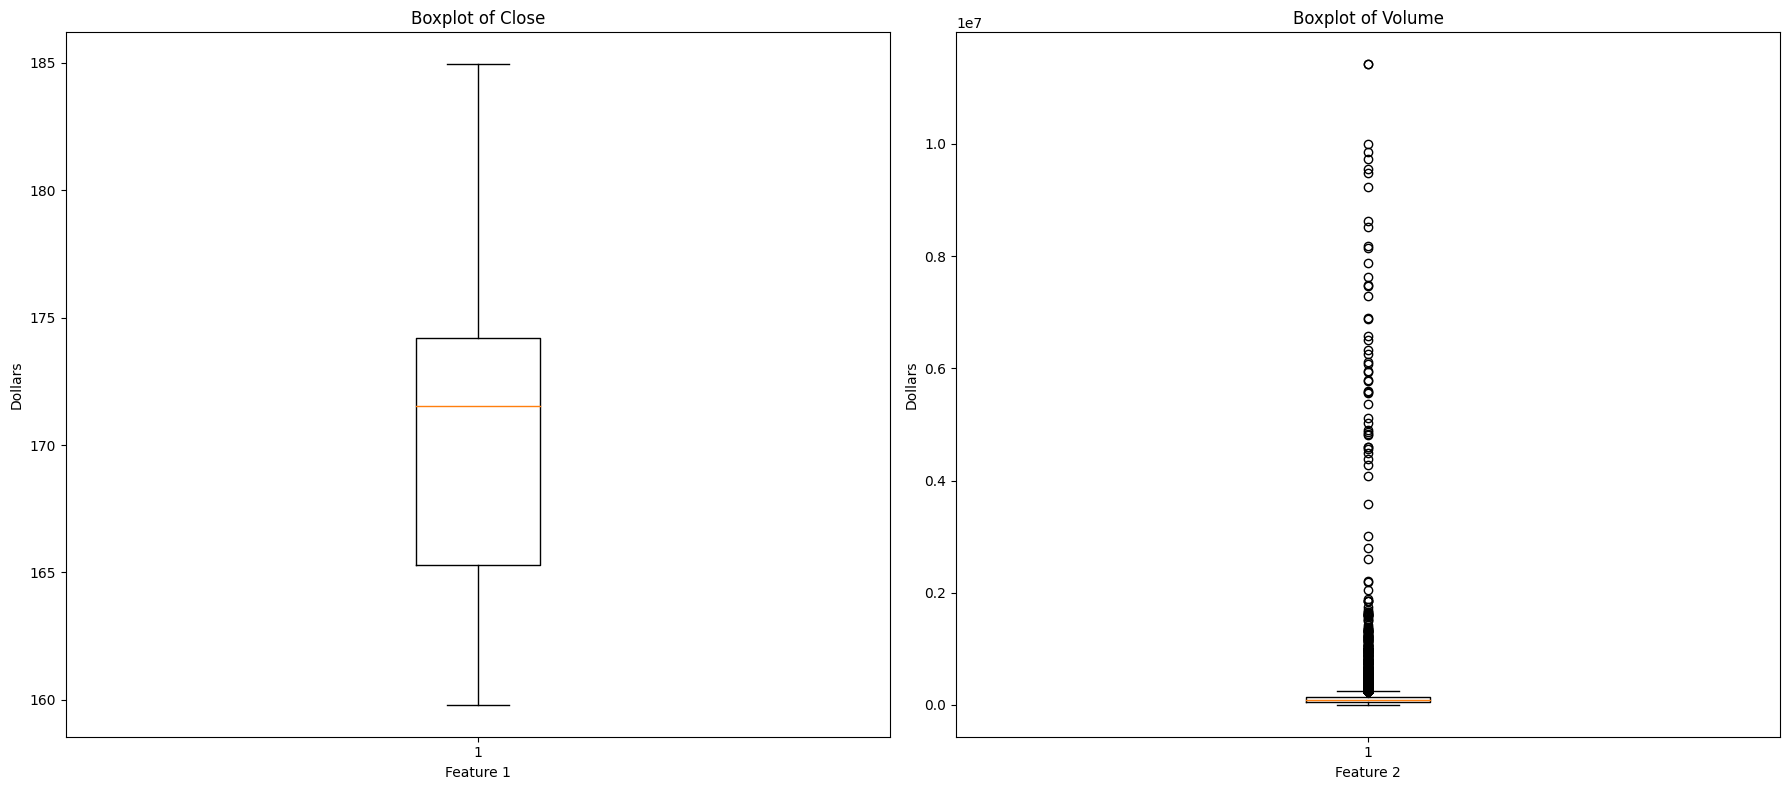

In [ ]:
X_new_vol = data[["Close", "Volume"]]
boxplot(X_new_vol)

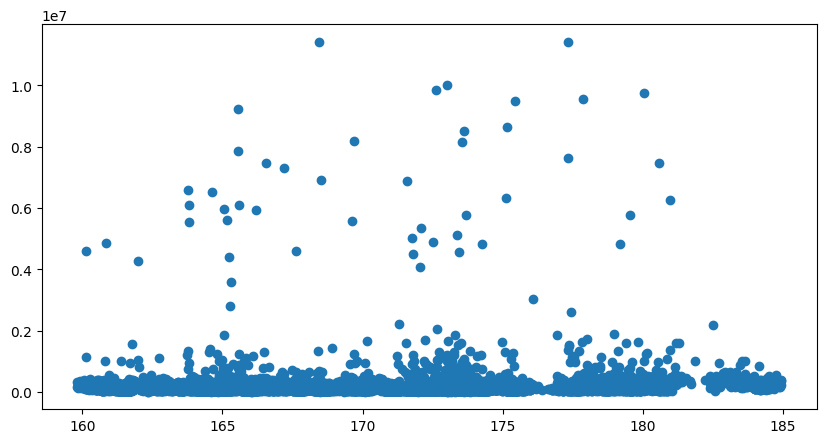

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data["Close"],data["Volume"])

#### New Features

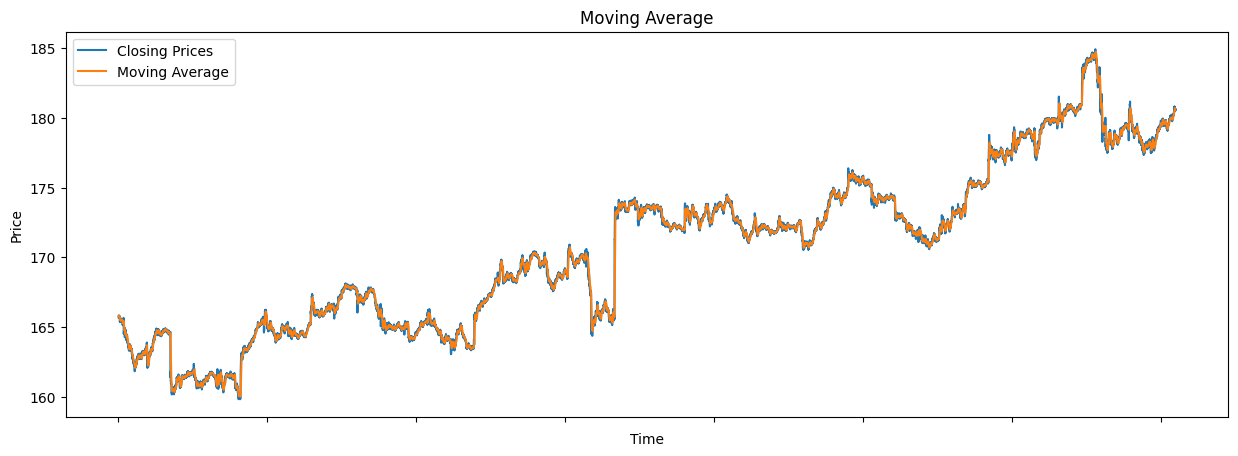

In [ ]:
##MA
plt.figure(figsize = (15,5))
plt.plot(data["Close"], label='Closing Prices')
plt.plot(data["MA"], label='Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Moving Average')
plt.show()


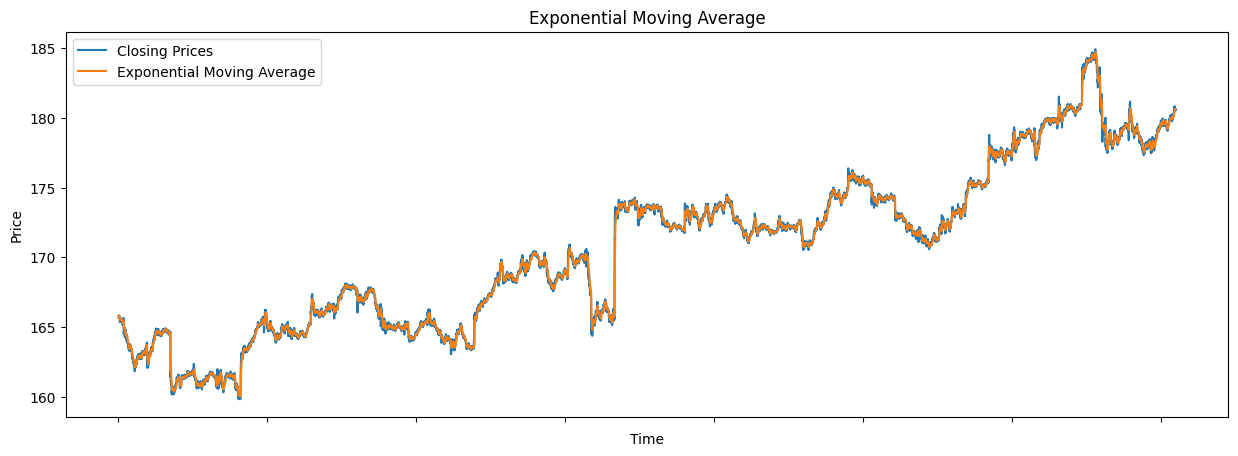

In [ ]:
##EMA
plt.figure(figsize = (15,5))
plt.plot(data["Close"], label='Closing Prices')
plt.plot(data["EMA"], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Exponential Moving Average')
plt.show()


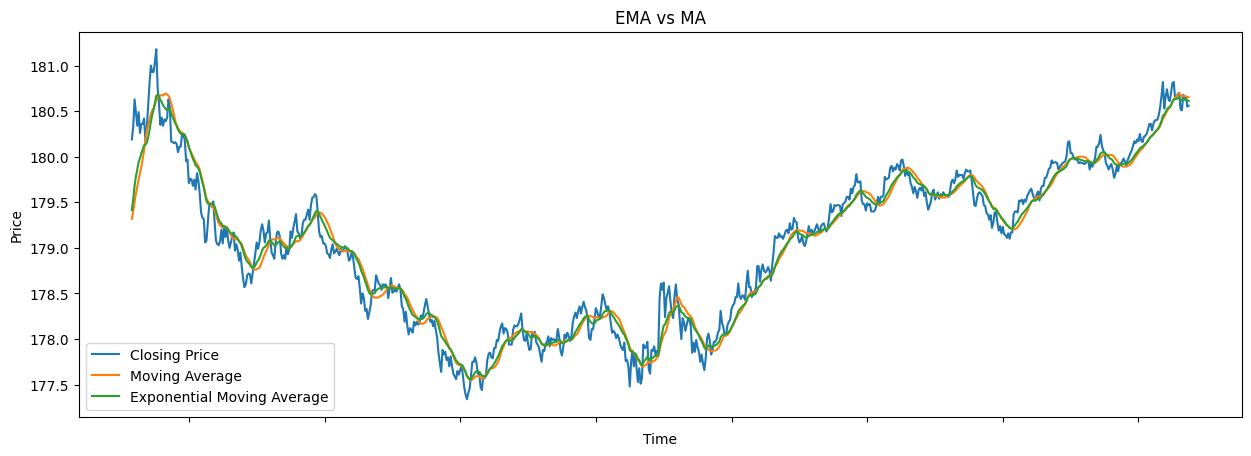

In [ ]:
##EMA vs MS
plt.figure(figsize = (15,5))
plt.plot(data["Close"][-780:], label='Closing Price')
plt.plot(data["MA"][-780:], label='Moving Average')
plt.plot(data["EMA"][-780:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('EMA vs MA')
plt.show()

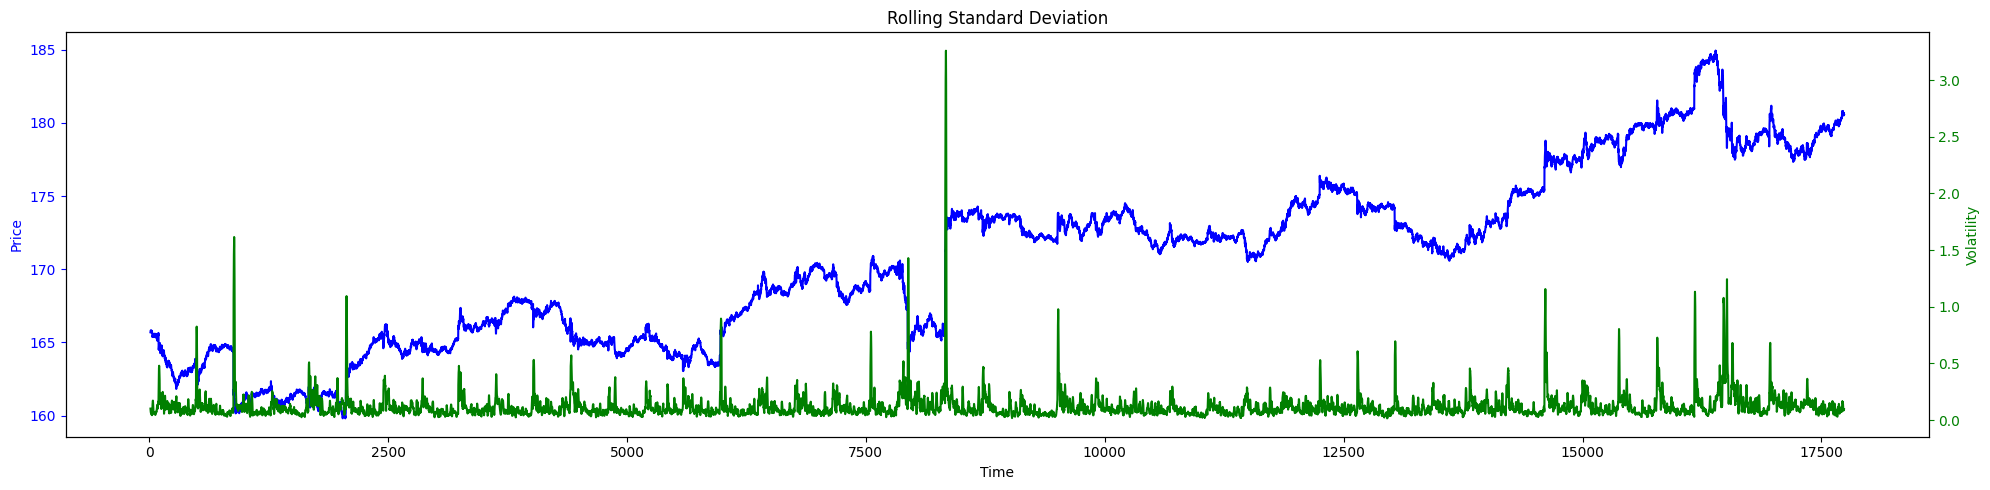

In [ ]:
## STD_DEV
fig, ax1 = plt.subplots(figsize = (20,5))

# Plot the closing prices on the primary y-axis
ax1.plot(data["Close"], label='Closing Prices', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for the rolling standard deviation
ax2 = ax1.twinx()
ax2.plot(data["std_dev"], label='Rolling Standard Deviation', color='g')
ax2.set_ylabel('Volatility', color='g')
ax2.tick_params('y', colors='g')

plt.title('Rolling Standard Deviation')
fig.tight_layout()
plt.show()

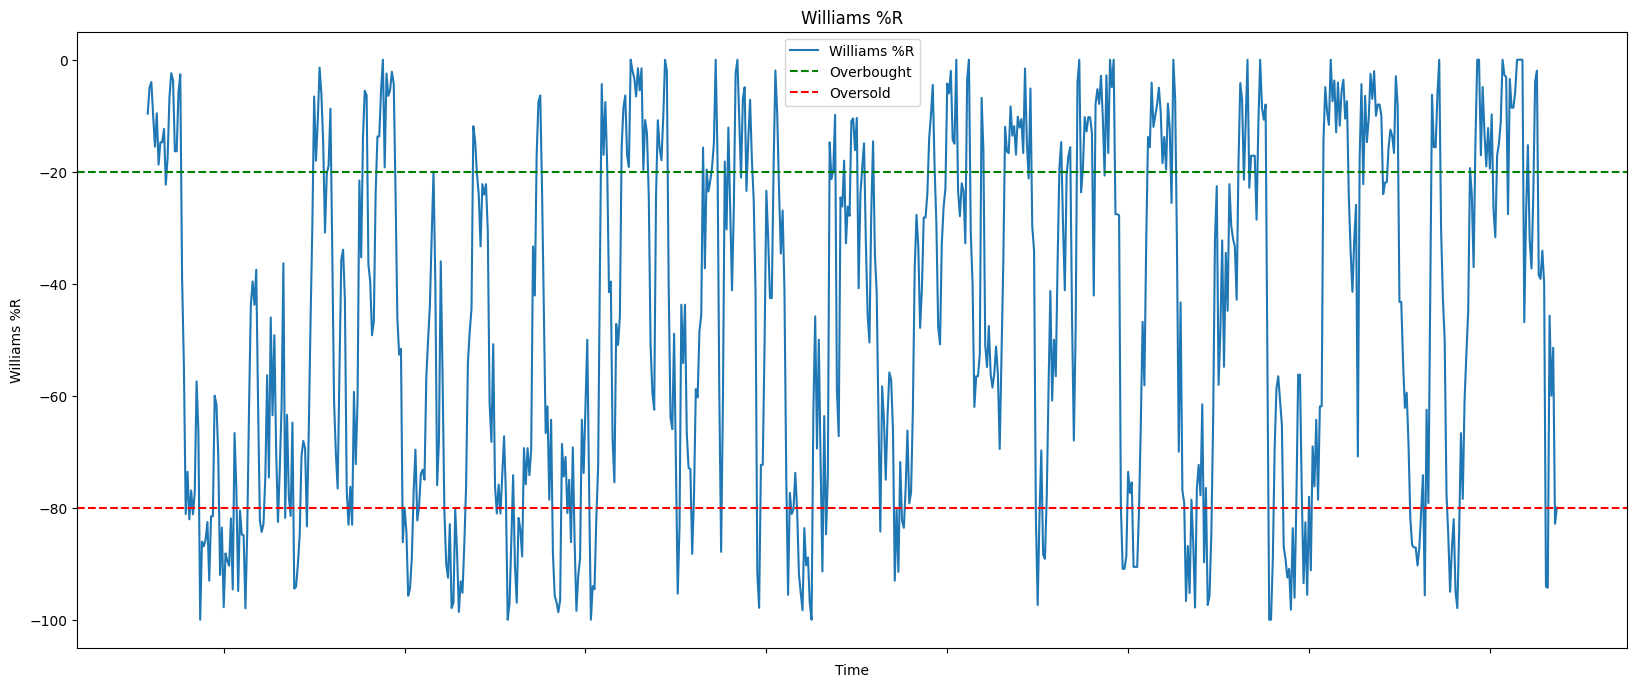

In [ ]:
## WILLIAMS %R
plt.figure(figsize = (20,8))
plt.plot(data["williams_percent_r"][-780:], label='Williams %R') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(-20, color='g', linestyle='--', label='Overbought')
plt.axhline(-80, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('Williams %R')
plt.title('Williams %R')
plt.show()

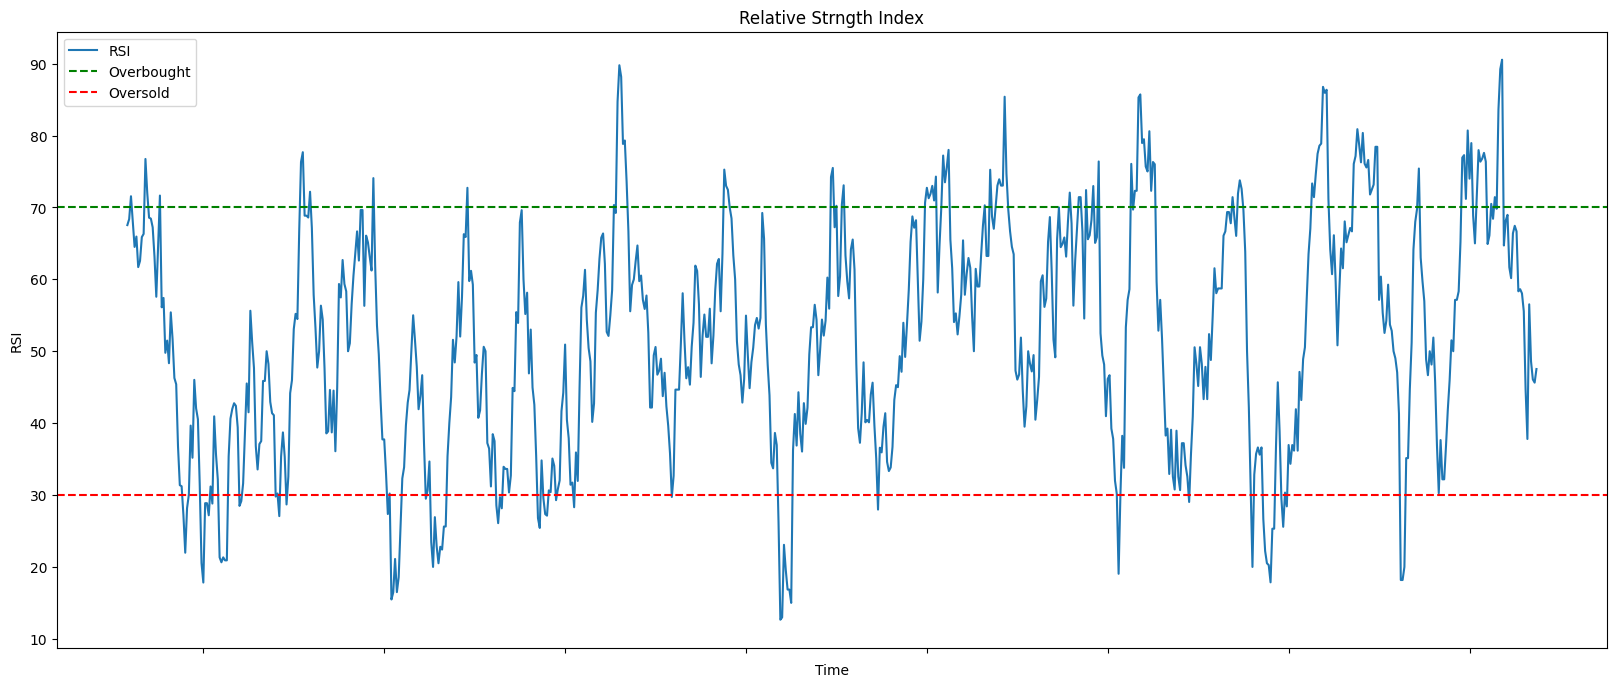

In [ ]:
##RSI
plt.figure(figsize = (20,8))
plt.plot(data["RSI"][-780:], label='RSI') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(70, color='g', linestyle='--', label='Overbought')
plt.axhline(30, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('RSI')
plt.title('Relative Strngth Index')
plt.show()

### Feature Selection

In [ ]:
data

Local Date Local Time   Close   Net  %Chg    Open     Low    High  \
13    2023-04-04   20:37:00  165.69  0.01  0.01  165.68  165.67  165.72   
14    2023-04-04   20:38:00  165.73  0.04  0.02  165.69  165.67  165.75   
15    2023-04-04   20:39:00  165.80  0.07  0.04  165.74  165.73  165.85   
16    2023-04-04   20:40:00  165.81  0.01  0.01  165.80  165.74  165.82   
17    2023-04-04   20:41:00  165.83  0.02  0.01  165.82  165.75  165.90   
...          ...        ...     ...   ...   ...     ...     ...     ...   
17733 2023-06-08   21:57:00  180.68  0.17  0.09  180.51  180.50  180.69   
17734 2023-06-08   21:58:00  180.63 -0.05 -0.03  180.68  180.59  180.68   
17735 2023-06-08   21:59:00  180.66  0.03  0.02  180.63  180.61  180.68   
17736 2023-06-08   22:00:00  180.55 -0.11 -0.06  180.66  180.54  180.69   
17737 2023-06-08   22:01:00  180.56  0.01  0.01  180.55  180.53  180.58   

          Volume            DateTime          MA   std_dev  \
13       50403.0 2023-04-04 20:37:00  165.770714  0.101183   
14       65580.0 2023-04-04 20:38:00  165.755000  0.087332   
15      115204.0 2023-04-04 20:39:00  165.749286  0.080905   
16       47306.0 2023-04-04 20:40:00  165.742857  0.070974   
17       97703.0 2023-04-04 20:41:00  165.740000  0.066100   
...          ...                 ...         ...       ...   
17733   282116.0 2023-06-08 21:57:00  180.670000  0.089012   
17734   216205.0 2023-06-08 21:58:00  180.667857  0.089630   
17735   282580.0 2023-06-08 21:59:00  180.662143  0.087194   
17736   645691.0 2023-06-08 22:00:00  180.655714  0.092130   
17737  7473588.0 2023-06-08 22:01:00  180.652143  0.094964   

       williams_percent_r         EMA        RSI   SMA_Net   EMA_Net  \
13             -73.913043  165.757681  51.236670 -0.018571 -0.010356   
14             -60.000000  165.753990  29.629630 -0.015714 -0.003642   
15             -41.025641  165.760125  42.592593 -0.005714  0.006177   
16             -31.428571  165.766775  41.509434 -0.006429  0.006687   
17             -25.714286  165.775205  46.153846 -0.002857  0.008462   
...                   ...         ...        ...       ...       ...   
17733          -45.714286  180.624691  56.521739  0.010000  0.008403   
17734          -60.000000  180.625399  48.598131 -0.002857  0.000616   
17735          -51.428571  180.630013  46.078431 -0.006429  0.004533   
17736          -82.857143  180.619344  45.631068 -0.006429 -0.010738   
17737          -80.000000  180.611432  47.524752 -0.003571 -0.007973   

       std_dev_Net  Trend  
13        0.041111      0  
14        0.043803      0  
15        0.046362      2  
16        0.046011      0  
17        0.045981      0  
...            ...    ...  
17733     0.107560      2  
17734     0.102764      1  
17735     0.100507      0  
17736     0.100507      1  
17737     0.100354      0  

[17725 rows x 19 columns]

In [ ]:
correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)

correlations

<ipython-input-77-ce59e57b9ad5>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)


%Chg                  0.357078
Net                   0.355213
std_dev_Net           0.216602
EMA_Net               0.159051
std_dev               0.142369
williams_percent_r    0.135679
SMA_Net               0.080400
RSI                   0.066364
Volume                0.050660
Close                 0.047945
High                  0.047633
EMA                   0.043894
MA                    0.043656
Open                  0.042417
Low                   0.041059
dtype: float64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17725 entries, 13 to 17737
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Local Date          17725 non-null  datetime64[ns]
 1   Local Time          17725 non-null  object        
 2   Close               17725 non-null  float64       
 3   Net                 17725 non-null  float64       
 4   %Chg                17725 non-null  float64       
 5   Open                17725 non-null  float64       
 6   Low                 17725 non-null  float64       
 7   High                17725 non-null  float64       
 8   Volume              17725 non-null  float64       
 9   DateTime            17725 non-null  datetime64[ns]
 10  MA                  17725 non-null  float64       
 11  std_dev             17725 non-null  float64       
 12  williams_percent_r  17725 non-null  float64       
 13  EMA                 17725 non-null  float64  

In [ ]:
from sklearn.feature_selection import mutual_info_classif
data = data.drop(['DateTime',"Local Date","Local Time"],axis = 1)

X_sample, y_sample = data.iloc[:,:-1],data.iloc[:,-1]
# Calculate mutual information
mi_scores = mutual_info_classif(X_sample, y_sample, random_state = 42)
# Create a dataframe of features and their mutual information scores
mi_scores_df = pd.DataFrame({'Feature': X_sample.columns, 'MI_Score': mi_scores})


In [ ]:
mi_scores_df

Feature  MI_Score
0                Close  0.014025
1                  Net  1.049514
2                 %Chg  0.988742
3                 Open  0.013163
4                  Low  0.002755
5                 High  0.003918
6               Volume  0.050065
7                   MA  0.009621
8              std_dev  0.025248
9   williams_percent_r  0.137056
10                 EMA  0.001765
11                 RSI  0.040816
12             SMA_Net  0.034878
13             EMA_Net  0.114088
14         std_dev_Net  0.043937

In [ ]:
columns = mi_scores_df["Feature"].iloc[np.where(mi_scores_df["MI_Score"] > 0.01)].tolist()
columns.append("Trend")
print(columns)

['Close', 'Net', '%Chg', 'Open', 'Volume', 'std_dev', 'williams_percent_r', 'RSI', 'SMA_Net', 'EMA_Net', 'std_dev_Net', 'Trend']


### Train, Validation and test split

### Keras data

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
X_parent = data[columns]#,"Volume","%Chg","williams_percent_r","MA","EMA","std_dev","RSI"

train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.45)


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns =columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 60)
X_v, y_v = generate_keras_dataset(valid_scaled ,lookback = 60)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 60)

In [ ]:
print("X_Train shape is:", X_tr.shape)
print("y_Train shape is:",  y_tr.shape)
print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (14120, 60, 11)
y_Train shape is: (14120,)
Validation set size is: (1535, 60, 11)
Testing set size is: (1890, 60, 11)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 8595, 1: 4410, 2: 4720}
Count of classes in the training set {0: 7058, 1: 3418, 2: 3644}
Count of classes in the validation set {0: 679, 1: 409, 2: 447}
Count of classes in the test set {0: 787, 1: 529, 2: 574}


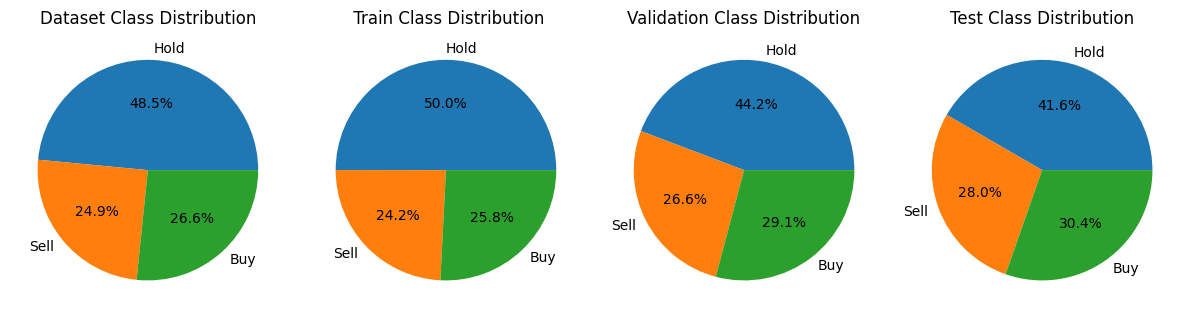

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 4, 1)
plt.pie(class_counts.values(), labels=labels, autopct='%1.1f%%')
plt.title("Dataset Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 4, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title(" Train Class Distribution")

# Plot the second pie chart in the middle subplot
plt.subplot(1, 4, 3)
plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 4, 4)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)

{0: 0.6668555775951639, 1: 1.3770236005461283, 2: 1.2916209293816319}


### Baseline LSTM

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LearningRateScheduler

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def step_decay(epoch):
    initial_lr = 5e-5  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 10    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)


In [ ]:
########## CON CLASS WEIGHT ############
inp_size=X_tr.shape[-1]
hidden_size=16
output_size=3
dropout_rate=0.6
num_layers= 4
keras_lstm = create_keras_model(inp_size=inp_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate, num_layers=num_layers)
lr = 1e-5
opt = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=0.9, beta_2=0.999,amsgrad=False)

# Train the model

y = tf.keras.utils.to_categorical(y_tr)
y_val = tf.keras.utils.to_categorical(y_v)


keras_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


keras_lstm.fit(X_tr, y,epochs=200, batch_size=64, validation_data = (X_v, y_val),class_weight = class_w)

#keras_lstm.summary()


In [ ]:
# Evaluate the model
y_val = tf.keras.utils.to_categorical(y_v)

loss, accuracy = keras_lstm.evaluate(X_v, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


# Test the model
y_test = tf.keras.utils.to_categorical(y_te)

loss, accuracy = keras_lstm.evaluate(X_te, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
######## RICORDATI CHE QUESTO è CON CLASS #########
# Make predictions on test data
y_pred = keras_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
class_labels = ["Hold",'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=class_labels, zero_division = 1))
accuracy = accuracy_score(y_te,y_pred_labels)
print("Accuracy", accuracy)


### AttentionLSTM

In [ ]:
inp_size= X_tr.shape[-1]
hidden_size=128
output_size=3
dropout_rate=0.5
num_layers=2

inputs = Input(shape=(X_tr.shape[1:]))
lstm_out,forward_h, backward_h, forward_c, backward_c = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True))(inputs)
#lstm_out = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(inputs)
lstm_out = Dropout(dropout_rate)(lstm_out)
for _ in range(num_layers-1):
  # LSTM layer
  lstm_out, forward_h, backward_h, forward_c, backward_c = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True))(lstm_out)
  #lstm_out = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(lstm_out)
  lstm_out = Dropout(dropout_rate)(lstm_out)
# Attention layer
attention = Attention()([lstm_out, lstm_out])

# Flatten layer to prepare the output of the attention layer for the Dense layer
flat = Flatten()(attention)

# Dense (output) layer
outputs = Dense(3, activation='softmax')(flat)
att_model = Model(inputs=inputs, outputs=outputs)


lr = 1e-6
opt = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=0.9, beta_2=0.999,amsgrad=False)
att_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model

y = tf.keras.utils.to_categorical(y_tr)
y_val = tf.keras.utils.to_categorical(y_v)

#att_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


att_model.fit(X_tr, y,epochs=50, batch_size=64, validation_data = (X_v,y_val), class_weight = class_w)

In [ ]:
######## RICORDATI CHE QUESTO è CON CLASS #########
# Make predictions on test data
y_pred = att_model.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
class_labels = ["Hold",'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=class_labels, zero_division = 1))
accuracy = accuracy_score(y_te,y_pred_labels)
print("Accuracy", accuracy)


### Transformer

In [ ]:
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=256,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[32],
    mlp_dropout=0.4,
    dropout=0.1,
)

lr = 1e-4

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]


model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=["sparse_categorical_accuracy"])
# Train the model

#y = tf.keras.utils.to_categorical(y_tr)
#y_val = tf.keras.utils.to_categorical(y_v)
#model_transformer.fit(X_tr, y, epochs=50, validation_data = (X_v,y_val), callbacks = callbacks,  class_weight = class_w)
model_transformer.fit(X_tr, y_tr, epochs=50, validation_data = (X_v,y_v), callbacks = callbacks,  class_weight = class_w)

Epoch 1/50
442/442 [==============================] - 26s 17ms/step - loss: 2.2298 - sparse_categorical_accuracy: 0.3433 - val_loss: 2.0954 - val_sparse_categorical_accuracy: 0.3101
Epoch 2/50
442/442 [==============================] - 6s 13ms/step - loss: 1.9873 - sparse_categorical_accuracy: 0.3644 - val_loss: 1.8962 - val_sparse_categorical_accuracy: 0.3362
Epoch 3/50
442/442 [==============================] - 7s 17ms/step - loss: 1.8157 - sparse_categorical_accuracy: 0.3858 - val_loss: 1.7545 - val_sparse_categorical_accuracy: 0.3336
Epoch 4/50
442/442 [==============================] - 6s 13ms/step - loss: 1.6713 - sparse_categorical_accuracy: 0.4069 - val_loss: 1.6103 - val_sparse_categorical_accuracy: 0.3674
Epoch 5/50
442/442 [==============================] - 8s 18ms/step - loss: 1.5577 - sparse_categorical_accuracy: 0.4142 - val_loss: 1.5639 - val_sparse_categorical_accuracy: 0.2736
Epoch 6/50
442/442 [==============================] - 6s 13ms/step - loss: 1.4620 - sparse_cat

In [ ]:
######## RICORDATI CHE QUESTO è CON CLASS #########
# Make predictions on test data
y_pred = model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
class_labels = ["Hold",'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=class_labels, zero_division = 1))
accuracy = accuracy_score(y_te,y_pred_labels)
print("Accuracy", accuracy)


60/60 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

        Hold       0.47      0.06      0.11       787
        Sell       0.28      0.71      0.41       529
         Buy       0.31      0.26      0.28       574

    accuracy                           0.30      1890
   macro avg       0.36      0.34      0.27      1890
weighted avg       0.37      0.30      0.25      1890

Accuracy 0.30264550264550266


### Random Forest Classifier

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

k = 8
cross_val = KFold(n_splits = k)
X = data[["Close","%Chg","MA","EMA","EMA_Net", "Trend"]]
X.iloc[:,:-1] = scaler.fit_transform(X.iloc[:,:-1])

x_trial, y_trial =  generate_keras_dataset(X,lookback = 60)

X = X_tr.reshape(X_tr.shape[0], -1)
x_trial = x_trial.reshape(x_trial.shape[0], -1)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state=42,class_weight = class_w)
# Perform cross-validation
scores = cross_val_predict(rf_classifier, x_trial, y_trial, cv=cross_val, verbose=3)

target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_trial, scores, target_names=target_names,zero_division = 1))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
cm = multilabel_confusion_matrix(y_trial, scores)
for i, matrix in enumerate(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap = "Blues")
    plt.title(f"Confusion Matrix for Label:{target_names[i]}"  )
    plt.show()

# Netflix min analysis

### Read the data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TESI/csv data/stock/Netflix_min.csv")

In [ ]:
data

In [ ]:
data.info()

In [ ]:
data = data.sort_index(ascending=False)
data.reset_index(drop = True, inplace=True)
data

###Data Preprocessing

Now I combine Date and Time into DateTime for graphic purposes.


In [ ]:
data["DateTime"] = pd.to_datetime(data["Local Date"] + ' ' +  data["Local Time"])

Clean the data to have the correct field types and filling missing values.

In [ ]:
data["%Chg"] = new_chg(data["%Chg"])
data["Volume"] = obj_to_float(data["Volume"])
data['Local Date'] = new_date(data['Local Date'])
data["Local Time"] = new_time(data["Local Time"])

In [ ]:
data.info()

 We need to realize that there are too many datapoints because date and time do not account for hours in which the market is closed and prices do not move. Therefore, we need to remove redundant times.

In [ ]:
## Removes the redundant hours, keeping the market working hours only. Being the US market, it
## corresponds to 15.30-22.01 in Italy.
#data = remove_redundant()
data.reset_index(drop=True, inplace=True)

In [ ]:
data["Net"].fillna(0.0, inplace = True)

In [ ]:
data.info()

In [ ]:
data = data.dropna()

#### Feature Engineering

In [ ]:
period = 10
# moving average
data['MA'] = data['Close'].copy().rolling(window=period).mean()

# Calculate standard deviation
data['std_dev'] = data['Close'].copy().rolling(window=period).std()

# Calculate Williams %R

data['williams_percent_r'] = calculate_williams_percent_r(data['High'], data['Low'], data['Close'], period)
# exponential moving average
data["EMA"] = calculate_ema(data,period)
# residual strength index
data["RSI"] = calculate_rsi(data,period)
data.fillna(data.mean(), inplace = True)
data['SMA_Net'] = data['Net'].rolling(window=period).mean()
data['EMA_Net'] = data['Net'].ewm(span=period, adjust=False).mean()
data['std_dev_Net'] = data['Net'].rolling(window=period).std()


In [ ]:
data.info()

In [ ]:
data.dropna(inplace=True)

In [ ]:
max_value = data['Volume'].max()
data['Volume'] = data['Volume'].replace(max_value, data['Volume'].where(data['Volume'] != max_value).max())

### Create Target

#### Set the multi-class target. It consists in either a price stays the same (0) or decrease more than 0.5 std (1) or increase more than 0.5 std (2).

In [ ]:
data["Trend"] = build_target(data["Net"])

#### Target

In [ ]:
tgt = data["Trend"]
grows, decrease, same = 0,0,0
for value in tgt:
  if value == 2:
    grows += 1
  elif value == 1:
    decrease += 1
  else:
    same += 1
class_labels = ["Hold",'Sell', 'Buy']
plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
plt.title("Class Distribution")
plt.legend()
n = len(tgt)
class_distr = [same/n, decrease/n, grows/n]
weight_tensor = loss_weights(class_distr)
for i , val in enumerate(weight_tensor.numpy()) :
  print("class",i,"is weighted",val)

### Some Visualizations

In [ ]:
correlation_matrix = data.corr()
correlation_matrix

<ipython-input-101-6617581d08be>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Close       Net      %Chg      Open       Low  \
Close               1.000000  0.020730  0.021025  0.999837  0.999852   
Net                 0.020730  1.000000  0.997703  0.003204  0.013946   
%Chg                0.021025  0.997703  1.000000  0.003547  0.014295   
Open                0.999837  0.003204  0.003547  1.000000  0.999814   
Low                 0.999852  0.013946  0.014295  0.999814  1.000000   
High                0.999735  0.010038  0.010341  0.999766  0.999601   
Volume              0.068782 -0.016858 -0.017838  0.069080  0.065327   
MA                  0.998871  0.002703  0.003111  0.999033  0.998896   
std_dev             0.121407 -0.021664 -0.021379  0.121766  0.117043   
williams_percent_r  0.051622  0.365209  0.366758  0.045107  0.047678   
EMA                 0.999190  0.004183  0.004563  0.999324  0.999199   
RSI                 0.051502  0.226286  0.227113  0.047514  0.049210   
SMA_Net             0.071562  0.284136  0.283708  0.066491  0.069548   
EMA_Net             0.071183  0.499042  0.497580  0.062252  0.067553   
std_dev_Net         0.142649 -0.102194 -0.102996  0.144486  0.137820   
Trend               0.079643  0.303344  0.303469  0.074341  0.073717   

                        High    Volume        MA   std_dev  \
Close               0.999735  0.068782  0.998871  0.121407   
Net                 0.010038 -0.016858  0.002703 -0.021664   
%Chg                0.010341 -0.017838  0.003111 -0.021379   
Open                0.999766  0.069080  0.999033  0.121766   
Low                 0.999601  0.065327  0.998896  0.117043   
High                1.000000  0.072336  0.998784  0.125953   
Volume              0.072336  1.000000  0.065010  0.292889   
MA                  0.998784  0.065010  1.000000  0.104198   
std_dev             0.125953  0.292889  0.104198  1.000000   
williams_percent_r  0.046927  0.039756  0.022131  0.044922   
EMA                 0.999088  0.065358  0.999940  0.106909   
RSI                 0.049109  0.051128  0.021707  0.092324   
SMA_Net             0.067948 -0.012884  0.040504 -0.040065   
EMA_Net             0.065096 -0.006336  0.035421 -0.039176   
std_dev_Net         0.148963  0.336118  0.147207  0.568535   
Trend               0.079976  0.126036  0.073809  0.162758   

                    williams_percent_r       EMA       RSI   SMA_Net  \
Close                         0.051622  0.999190  0.051502  0.071562   
Net                           0.365209  0.004183  0.226286  0.284136   
%Chg                          0.366758  0.004563  0.227113  0.283708   
Open                          0.045107  0.999324  0.047514  0.066491   
Low                           0.047678  0.999199  0.049210  0.069548   
High                          0.046927  0.999088  0.049109  0.067948   
Volume                        0.039756  0.065358  0.051128 -0.012884   
MA                            0.022131  0.999940  0.021707  0.040504   
std_dev                       0.044922  0.106909  0.092324 -0.040065   
williams_percent_r            1.000000  0.026704  0.819065  0.628497   
EMA                           0.026704  1.000000  0.025723  0.044716   
RSI                           0.819065  0.025723  1.000000  0.764914   
SMA_Net                       0.628497  0.044716  0.764914  1.000000   
EMA_Net                       0.698520  0.040467  0.673810  0.880743   
std_dev_Net                  -0.009130  0.146119 -0.002617 -0.282673   
Trend                         0.148395  0.074207  0.090974  0.089440   

                     EMA_Net  std_dev_Net     Trend  
Close               0.071183     0.142649  0.079643  
Net                 0.499042    -0.102194  0.303344  
%Chg                0.497580    -0.102996  0.303469  
Open                0.062252     0.144486  0.074341  
Low                 0.067553     0.137820  0.073717  
High                0.065096     0.148963  0.079976  
Volume             -0.006336     0.336118  0.126036  
MA                  0.035421     0.147207  0.073809  
std_dev            -0.039176    

<Axes: >

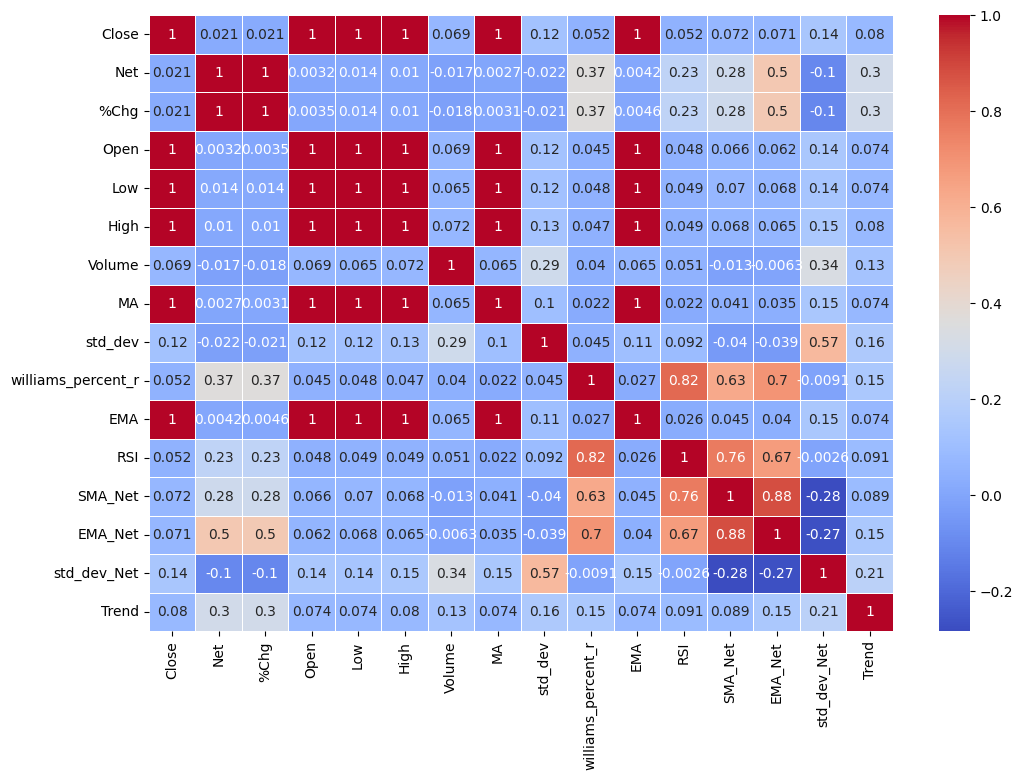

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True ,linewidths=0.5, cmap = "coolwarm")

It is evident how Close, Open, Low, High are actually collinear. Therefore, only one of them can be included in the model to avoid all the multicollinearity issues. For reliability purposes, I stand for choosing "Close". Having noted this, it is also clear that "%Chg" and "Net" are collinear and for the aforementioned reason, I prefer keeping "%Chg". Finally, I have Result which has a high correlation with "%Chg" as it is obtained from it. For this, I keep Result as target variable.

#### Analyse closing prices

In [ ]:
data["Close"].describe()

count    19584.000000
mean       337.765849
std         19.127064
min        293.180000
25%        325.337500
50%        334.000000
75%        343.200000
max        404.220000
Name: Close, dtype: float64

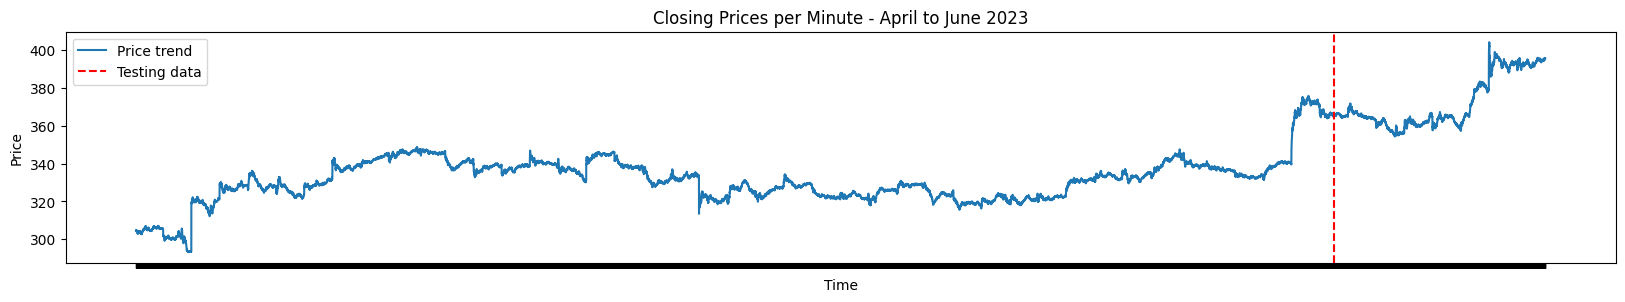

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["DateTime"].astype(str), data["Close"])
plt.xlabel('Time')
plt.ylabel('Price')

plt.axvline(int(len(data["DateTime"])*0.85), color='r', linestyle='--', label='Testing data')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.title('Closing Prices per Minute - April to June 2023')
plt.legend(["Price trend","Testing data"],fontsize="10")

Text(0.5, 1.0, 'Count of closing price values')

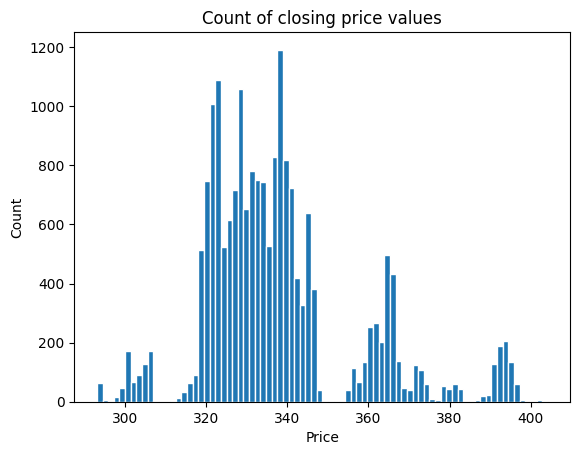

In [ ]:
plt.hist(data["Close"],edgecolor='white', bins = 80)
plt.ylabel("Count")
plt.xlabel("Price")
plt.title("Count of closing price values")

Clearly not normally distributed, they need normalization(applied after splitting training-validation-test sets).

#### Volume

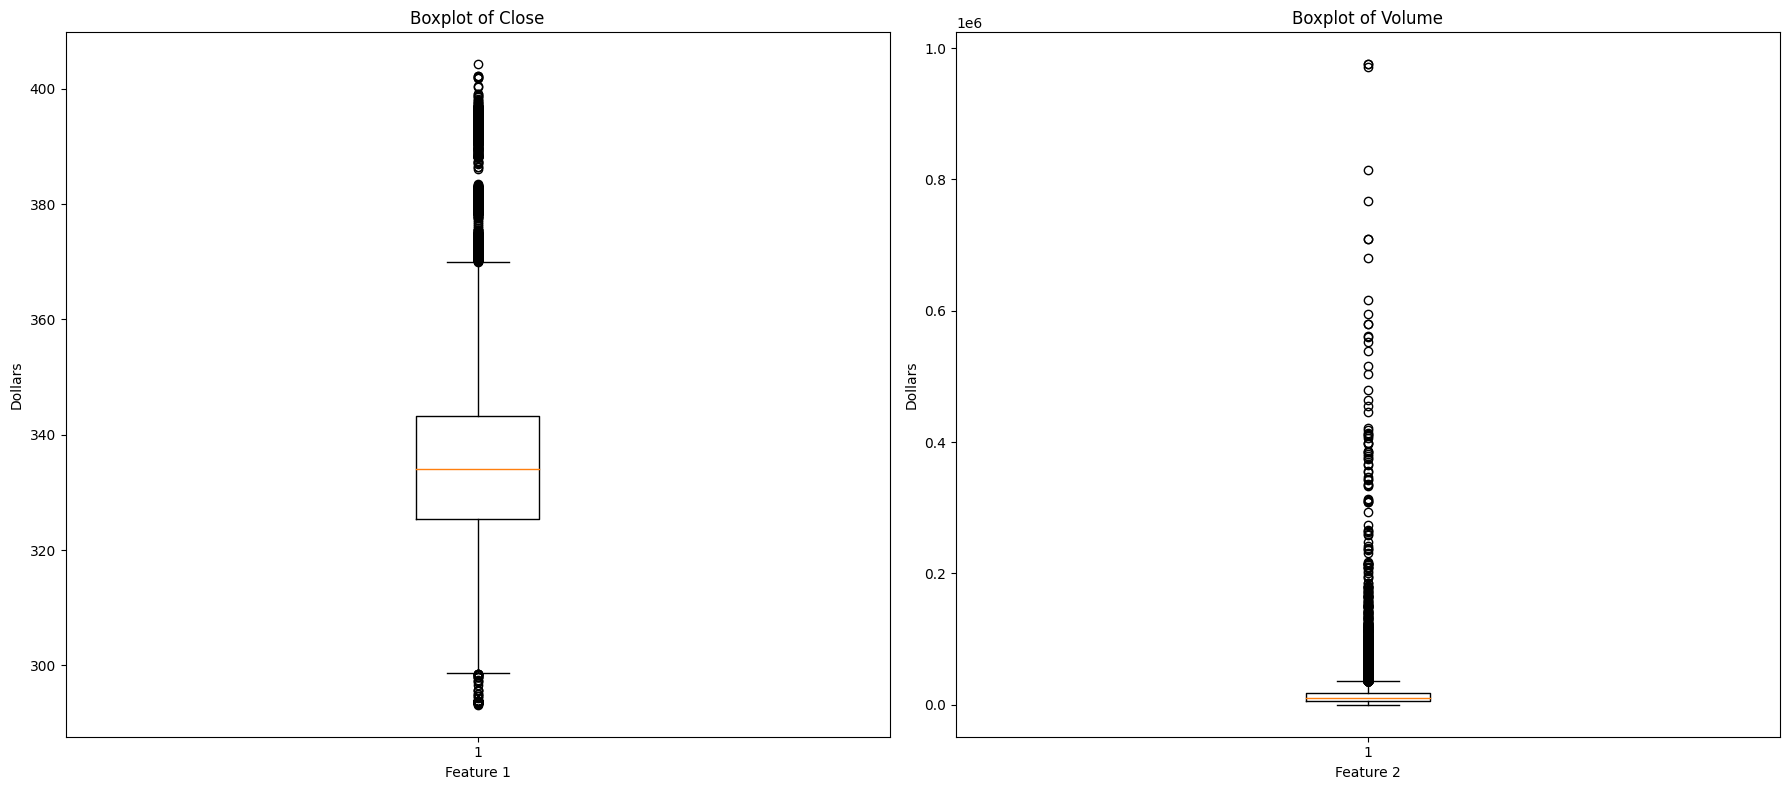

In [ ]:
X_viz = data[["Close", "Volume"]]
boxplot(X_viz)

It is clear that Volume shows exrteme outliers but they are crucial in identifying possible price trends as it represents the level of market activity and liquidity. Therefore, after dropping the very extreme outlier, all the rest is kept.

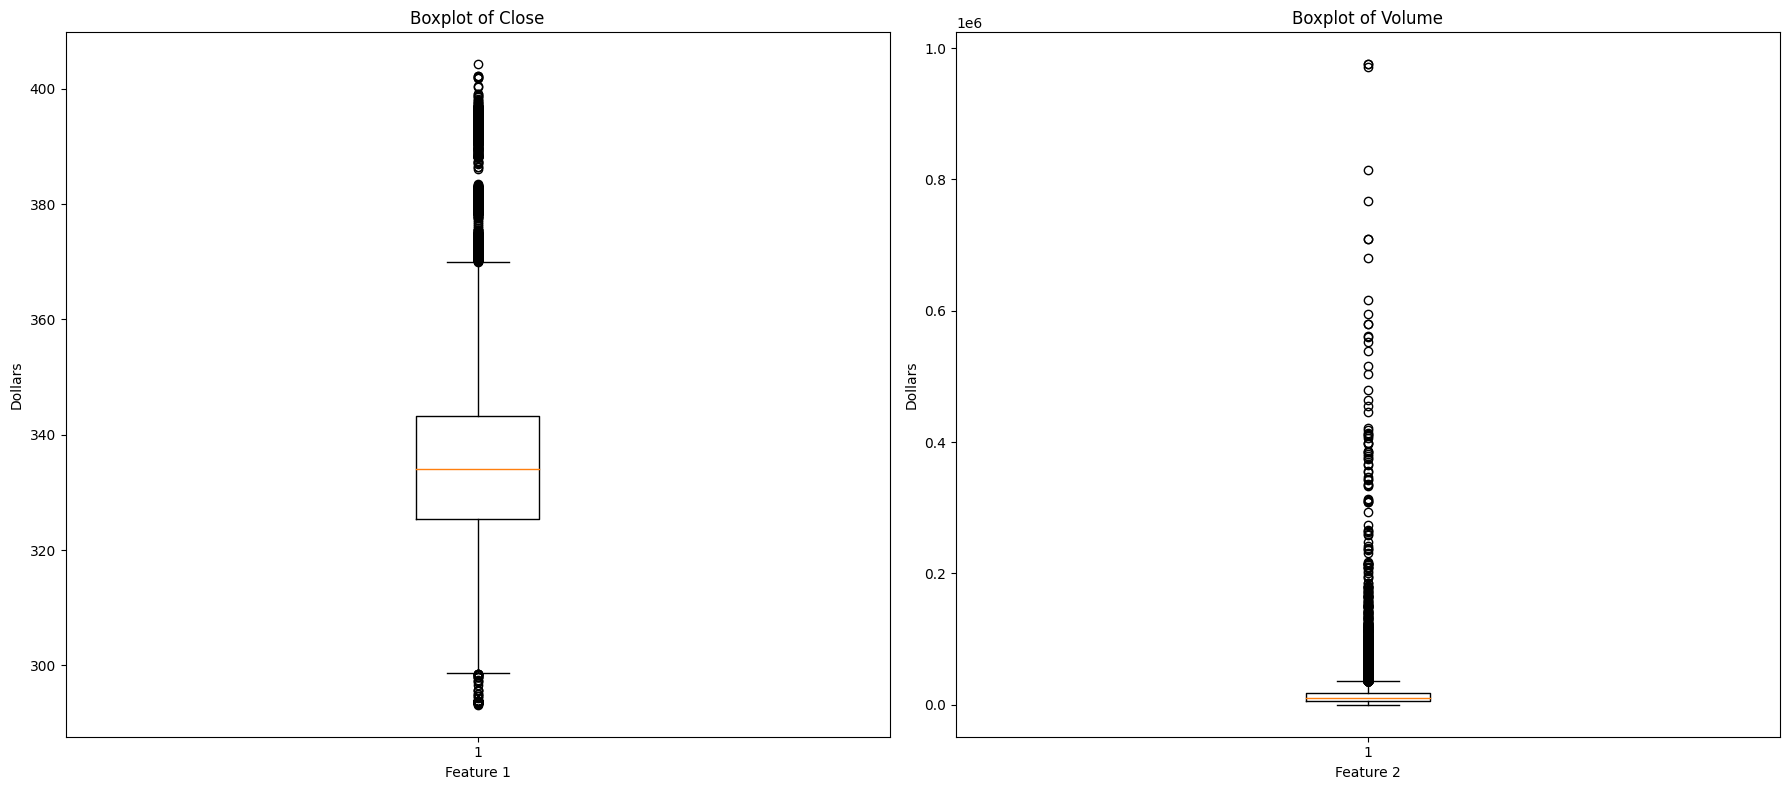

In [ ]:
X_new_vol = data[["Close", "Volume"]]
boxplot(X_new_vol)

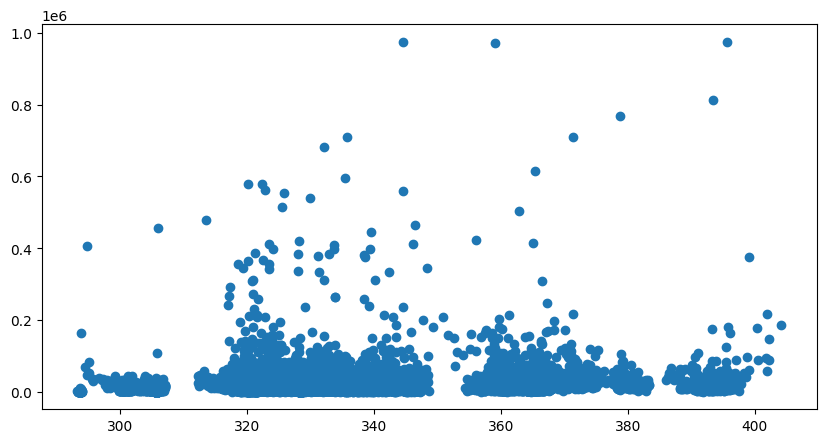

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data["Close"],data["Volume"])

#### New Features

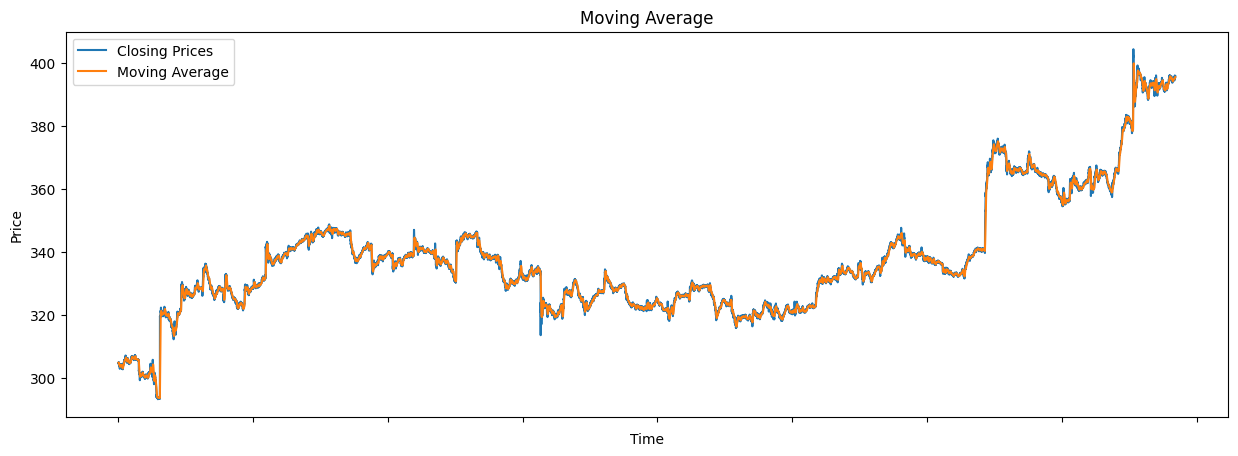

In [ ]:
##MA
plt.figure(figsize = (15,5))
plt.plot(data["Close"], label='Closing Prices')
plt.plot(data["MA"], label='Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Moving Average')
plt.show()


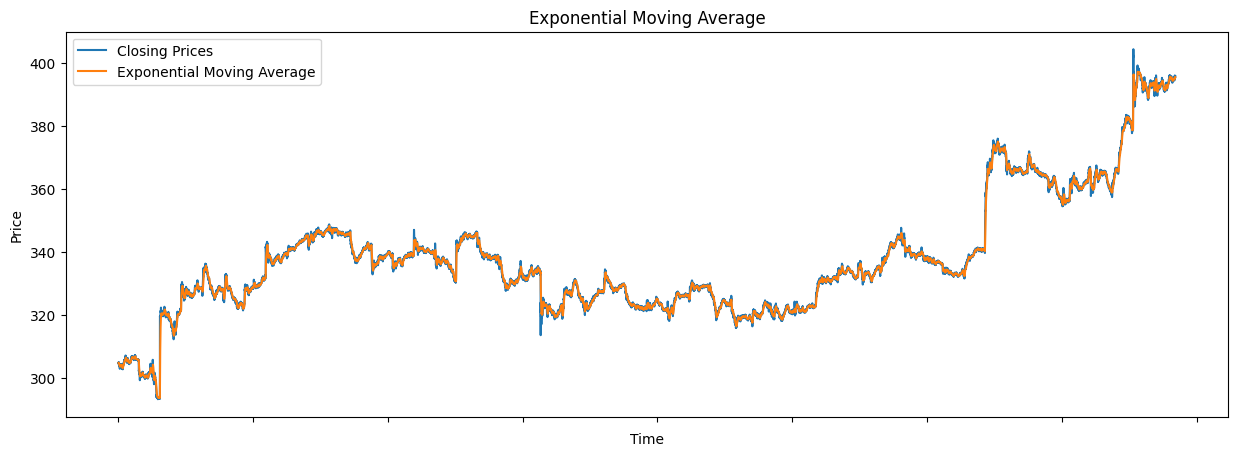

In [ ]:
##EMA
plt.figure(figsize = (15,5))
plt.plot(data["Close"], label='Closing Prices')
plt.plot(data["EMA"], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Exponential Moving Average')
plt.show()


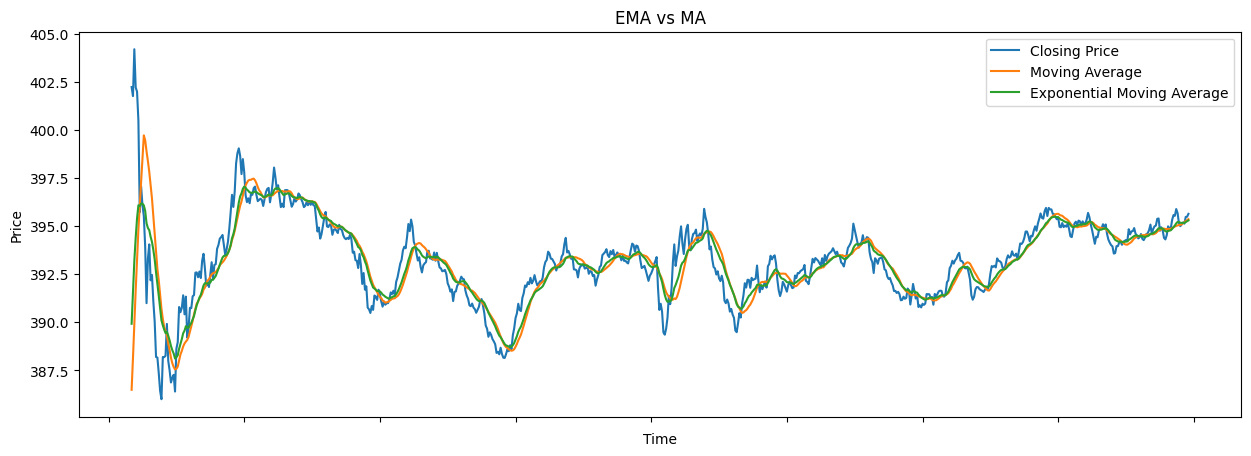

In [ ]:
##EMA vs MS
plt.figure(figsize = (15,5))
plt.plot(data["Close"][-780:], label='Closing Price')
plt.plot(data["MA"][-780:], label='Moving Average')
plt.plot(data["EMA"][-780:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('EMA vs MA')
plt.show()

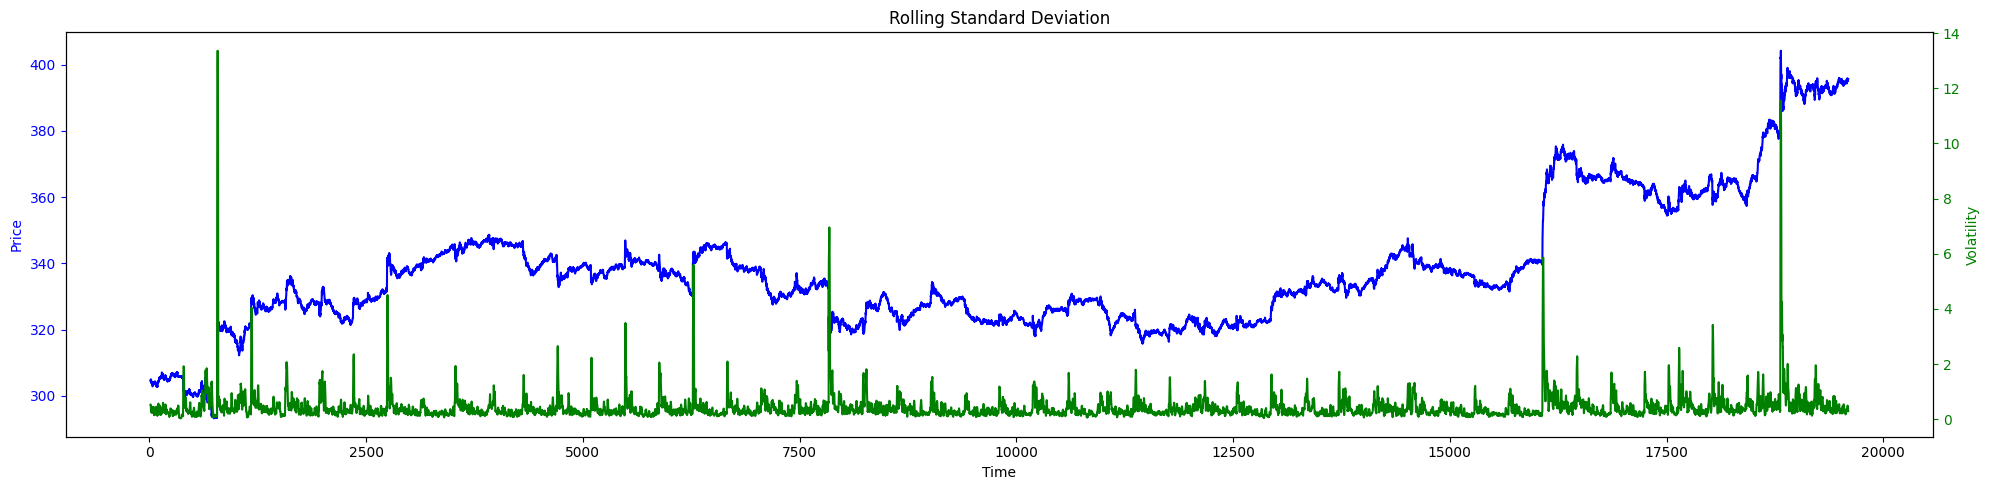

In [ ]:
## STD_DEV
fig, ax1 = plt.subplots(figsize = (20,5))

# Plot the closing prices on the primary y-axis
ax1.plot(data["Close"], label='Closing Prices', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for the rolling standard deviation
ax2 = ax1.twinx()
ax2.plot(data["std_dev"], label='Rolling Standard Deviation', color='g')
ax2.set_ylabel('Volatility', color='g')
ax2.tick_params('y', colors='g')

plt.title('Rolling Standard Deviation')
fig.tight_layout()
plt.show()

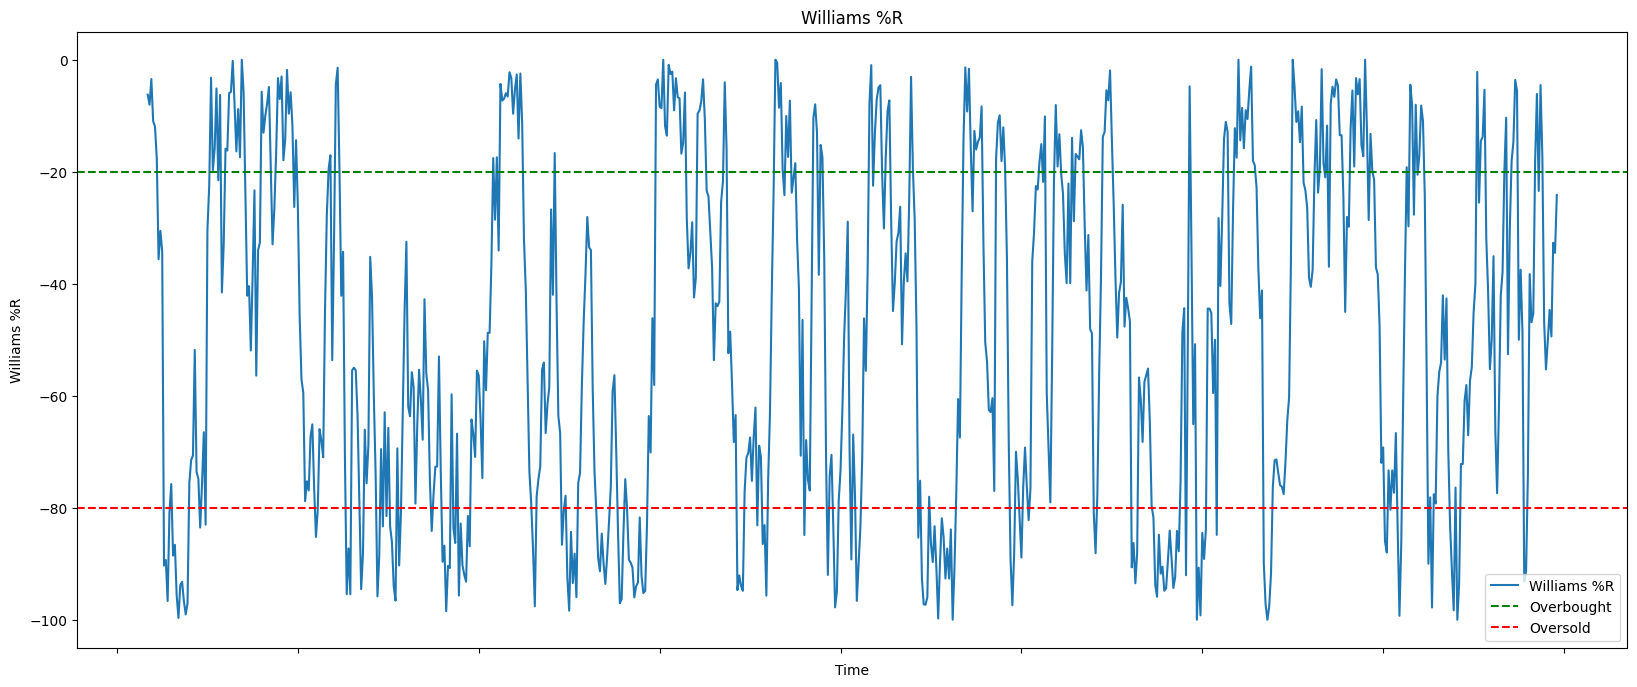

In [ ]:
## WILLIAMS %R
plt.figure(figsize = (20,8))
plt.plot(data["williams_percent_r"][-780:], label='Williams %R') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(-20, color='g', linestyle='--', label='Overbought')
plt.axhline(-80, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('Williams %R')
plt.title('Williams %R')
plt.show()

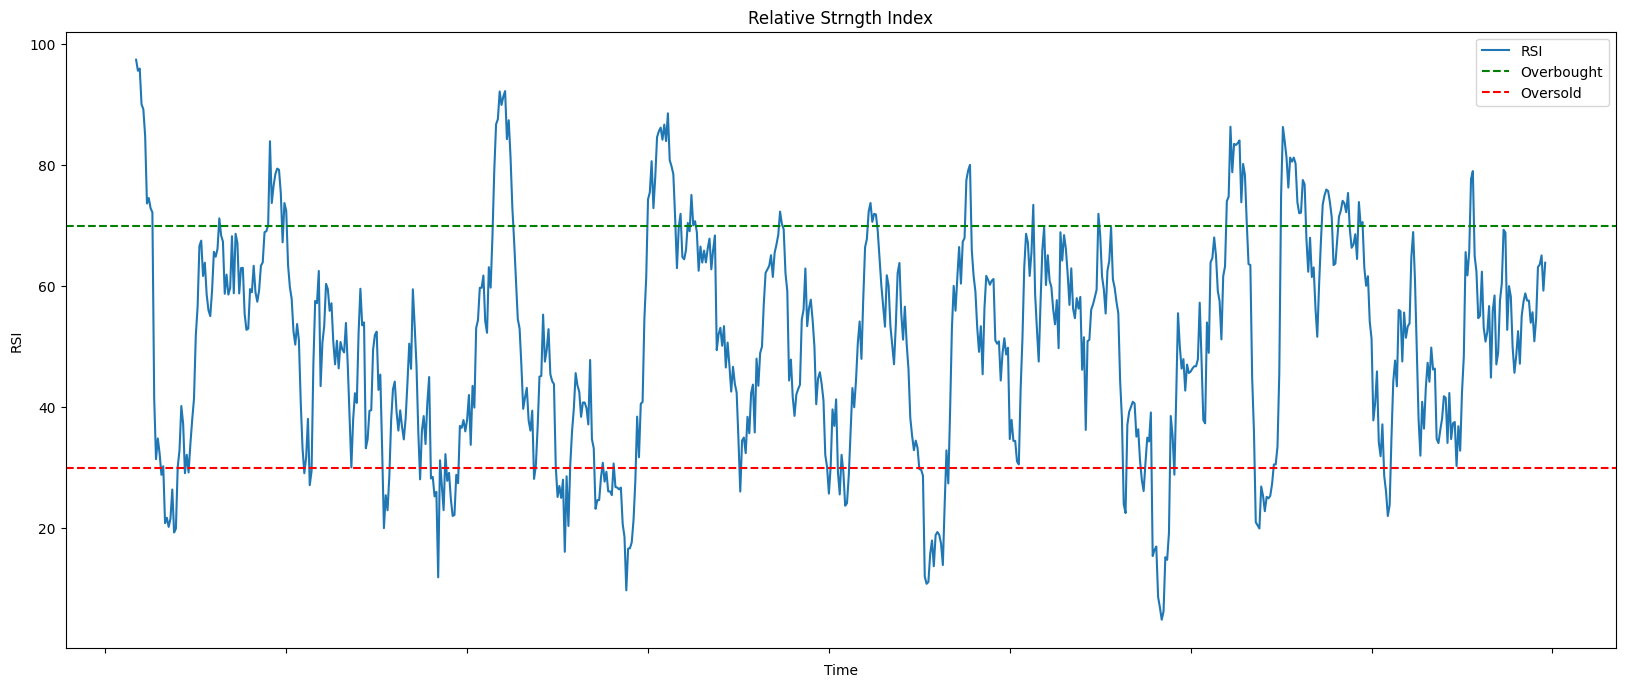

In [ ]:
##RSI
plt.figure(figsize = (20,8))
plt.plot(data["RSI"][-780:], label='RSI') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(70, color='g', linestyle='--', label='Overbought')
plt.axhline(30, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('RSI')
plt.title('Relative Strngth Index')
plt.show()

### Feature Selection

In [ ]:
correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)

correlations

In [ ]:
data.info()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
data = data.drop(['DateTime',"Local Date","Local Time"],axis = 1)

X_sample, y_sample = data.iloc[:,:-1],data.iloc[:,-1]
# Calculate mutual information
mi_scores = mutual_info_classif(X_sample, y_sample, random_state = 42)
# Create a dataframe of features and their mutual information scores
mi_scores_df = pd.DataFrame({'Feature': X_sample.columns, 'MI_Score': mi_scores})


In [ ]:
mi_scores_df

In [ ]:
columns = mi_scores_df["Feature"].iloc[np.where(mi_scores_df["MI_Score"] > 0.05)].tolist()
columns.append("Trend")
print(columns)

### Train, Validation and test split

### Keras data

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
X_parent = data[columns]#,"Volume","%Chg","williams_percent_r","MA","EMA","std_dev","RSI"

train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.45)


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns =columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 60)
X_v, y_v = generate_keras_dataset(valid_scaled ,lookback = 60)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 60)

In [ ]:
print("X_Train shape is:", X_tr.shape)
print("y_Train shape is:",  y_tr.shape)
print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 4, 1)
plt.pie(class_counts.values(), labels=labels, autopct='%1.1f%%')
plt.title("Dataset Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 4, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title("Train Class Distribution")

# Plot the second pie chart in the middle subplot
plt.subplot(1, 4, 3)
plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 4, 4)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)

### Baseline LSTM

In [ ]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def step_decay(epoch):
    initial_lr = 5e-4  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 8    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)


In [ ]:
########## CON CLASS WEIGHT ############
inp_size=X_tr.shape[-1]
hidden_size=16
output_size=3
dropout_rate=0.0
num_layers= 10
l2_rate = 0
keras_lstm = create_keras_model(inp_size=inp_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
lr = 5e-5
opt = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=0.9, beta_2=0.999,amsgrad=False)
callbacks = [
EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Train the model

keras_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])

class_w = calculate_class_weights(y_tr)
keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=32, validation_data = (X_v, y_v),callbacks = callbacks,class_weight = class_w)

#keras_lstm.summary()


Epoch 1/10
1016/1016 [==============================] - 59s 34ms/step - loss: 1.2236 - sparse_categorical_accuracy: 0.6058 - val_loss: 0.9788 - val_sparse_categorical_accuracy: 0.5772 - lr: 5.0000e-04
Epoch 2/10
1016/1016 [==============================] - 32s 32ms/step - loss: 1.2137 - sparse_categorical_accuracy: 0.6136 - val_loss: 0.9975 - val_sparse_categorical_accuracy: 0.5469 - lr: 5.0000e-04
Epoch 3/10
1016/1016 [==============================] - 32s 31ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.9367 - val_sparse_categorical_accuracy: 0.5702 - lr: 5.0000e-04
Epoch 4/10
1016/1016 [==============================] - 31s 30ms/step - loss: 1.2002 - sparse_categorical_accuracy: 0.6133 - val_loss: 0.9757 - val_sparse_categorical_accuracy: 0.5769 - lr: 5.0000e-04
Epoch 5/10
1016/1016 [==============================] - 32s 32ms/step - loss: 1.1911 - sparse_categorical_accuracy: 0.6152 - val_loss: 0.9407 - val_sparse_categorical_accuracy: 0.5944 - lr: 5.0000

In [ ]:
# Evaluate the model
y_val = tf.keras.utils.to_categorical(y_v)

loss, accuracy = keras_lstm.evaluate(X_v, y_v)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


# Test the model
y_test = tf.keras.utils.to_categorical(y_te)

loss, accuracy = keras_lstm.evaluate(X_te, y_te)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

113/113 [==============================] - 1s 13ms/step - loss: 0.9011 - sparse_categorical_accuracy: 0.6019
Validation Loss: 0.9011
Validation Accuracy: 0.6019
138/138 [==============================] - 2s 13ms/step - loss: 1.0109 - sparse_categorical_accuracy: 0.5122
Test Loss: 1.0109
Test Accuracy: 0.5122


In [ ]:
######## RICORDATI CHE QUESTO è CON CLASS #########
# Make predictions on test data
y_pred = keras_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
class_labels = ["Hold",'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=class_labels, zero_division = 1))
accuracy = accuracy_score(y_te,y_pred_labels)
print("Accuracy", accuracy)


138/138 [==============================] - 5s 14ms/step
              precision    recall  f1-score   support

        Hold       0.66      0.70      0.68      2520
        Sell       0.25      0.28      0.27       917
         Buy       0.35      0.25      0.29       979

    accuracy                           0.51      4416
   macro avg       0.42      0.41      0.41      4416
weighted avg       0.51      0.51      0.51      4416

Accuracy 0.5122282608695652


### AttentionLSTM

In [ ]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def step_decay(epoch):
    initial_lr = 5e-3  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 2    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)


In [ ]:
inp_size= X_tr.shape[-1]
hidden_size=16
output_size=3
dropout_rate=0.05
num_layers=12

inputs = Input(shape=(X_tr.shape[1:]))
lstm_out,forward_h, backward_h, forward_c, backward_c = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True))(inputs)
#lstm_out = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(inputs)
lstm_out = Dropout(dropout_rate)(lstm_out)
for _ in range(num_layers-1):
  # LSTM layer
  lstm_out, forward_h, backward_h, forward_c, backward_c = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True))(lstm_out)
  #lstm_out = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(lstm_out)
  lstm_out = Dropout(dropout_rate)(lstm_out)
# Attention layer
attention = Attention()([lstm_out, lstm_out])

# Flatten layer to prepare the output of the attention layer for the Dense layer
flat = Flatten()(attention)

# Dense (output) layer
outputs = Dense(3, activation='softmax')(flat)
att_model = Model(inputs=inputs, outputs=outputs)

callbacks = [
EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
att_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Train the model
class_w =calculate_class_weights(y_tr)
att_model.fit(X_tr, y_tr,epochs=20, batch_size=64, validation_data = (X_v,y_v),callbacks =callbacks , class_weight = class_w)

Epoch 1/20
508/508 [==============================] - 100s 102ms/step - loss: 1.2105 - sparse_categorical_accuracy: 0.5901 - val_loss: 0.9072 - val_sparse_categorical_accuracy: 0.5813 - lr: 0.0050
Epoch 2/20
508/508 [==============================] - 41s 81ms/step - loss: 1.1845 - sparse_categorical_accuracy: 0.6142 - val_loss: 0.9466 - val_sparse_categorical_accuracy: 0.5788 - lr: 0.0025
Epoch 3/20
508/508 [==============================] - 42s 82ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.6245 - val_loss: 0.9051 - val_sparse_categorical_accuracy: 0.6024 - lr: 0.0025
Epoch 4/20
508/508 [==============================] - 42s 84ms/step - loss: 1.1714 - sparse_categorical_accuracy: 0.6214 - val_loss: 0.9033 - val_sparse_categorical_accuracy: 0.6097 - lr: 0.0012
Epoch 5/20
508/508 [==============================] - 41s 81ms/step - loss: 1.1679 - sparse_categorical_accuracy: 0.6195 - val_loss: 0.9252 - val_sparse_categorical_accuracy: 0.5838 - lr: 0.0012
Epoch 6/20
508/508 [===

In [ ]:
######## RICORDATI CHE QUESTO è CON CLASS #########
# Make predictions on test data
y_pred = att_model.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
class_labels = ["Hold",'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=class_labels, zero_division = 1))
accuracy = accuracy_score(y_te,y_pred_labels)
print("Accuracy", accuracy)


138/138 [==============================] - 12s 28ms/step
              precision    recall  f1-score   support

        Hold       0.67      0.66      0.66      2520
        Sell       0.32      0.18      0.23       917
         Buy       0.27      0.39      0.31       979

    accuracy                           0.50      4416
   macro avg       0.42      0.41      0.40      4416
weighted avg       0.51      0.50      0.50      4416

Accuracy 0.4988677536231884


### Transformer

In [ ]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def step_decay(epoch):
    initial_lr = 1e-3  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 2    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)


In [ ]:
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=16,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[16],
    mlp_dropout=0.0,
    dropout=0.05,
)

lr = 1e-6

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), lr_scheduler]

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=["sparse_categorical_accuracy"])
# Train the model

#y = tf.keras.utils.to_categorical(y_tr)
#y_val = tf.keras.utils.to_categorical(y_v)
#model_transformer.fit(X_tr, y, epochs=50, validation_data = (X_v,y_val), callbacks = callbacks,  class_weight = class_w)
model_transformer.fit(X_tr, y_tr, epochs=50, batch_size = 64, validation_data = (X_v,y_v), callbacks = callbacks,  class_weight = class_w)

In [ ]:
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=16,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[16],
    mlp_dropout=0.0,
    dropout=0.05,
)

lr = 1e-6

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), lr_scheduler]

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=["sparse_categorical_accuracy"])
# Train the model

#y = tf.keras.utils.to_categorical(y_tr)
#y_val = tf.keras.utils.to_categorical(y_v)
#model_transformer.fit(X_tr, y, epochs=50, validation_data = (X_v,y_val), callbacks = callbacks,  class_weight = class_w)
model_transformer.fit(X_tr, y_tr, epochs=50, batch_size = 64, validation_data = (X_v,y_v), callbacks = callbacks,  class_weight = class_w)

Epoch 1/50
508/508 [==============================] - 56s 47ms/step - loss: 1.2440 - sparse_categorical_accuracy: 0.6040 - val_loss: 0.9397 - val_sparse_categorical_accuracy: 0.5836 - lr: 0.0010
Epoch 2/50
508/508 [==============================] - 23s 45ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.6145 - val_loss: 0.9887 - val_sparse_categorical_accuracy: 0.5330 - lr: 5.0000e-04
Epoch 3/50
508/508 [==============================] - 24s 46ms/step - loss: 1.1970 - sparse_categorical_accuracy: 0.6128 - val_loss: 0.9896 - val_sparse_categorical_accuracy: 0.5228 - lr: 5.0000e-04
Epoch 4/50
508/508 [==============================] - 24s 48ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.5669 - lr: 2.5000e-04
Epoch 5/50
508/508 [==============================] - 23s 46ms/step - loss: 1.1890 - sparse_categorical_accuracy: 0.6121 - val_loss: 0.9917 - val_sparse_categorical_accuracy: 0.5358 - lr: 2.5000e-04
Epoch 6/5

In [ ]:
######## RICORDATI CHE QUESTO è CON CLASS #########
# Make predictions on test data
y_pred = model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
class_labels = ["Hold",'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=class_labels, zero_division = 1))
accuracy = accuracy_score(y_te,y_pred_labels)
print("Accuracy", accuracy)


138/138 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

        Hold       0.61      0.66      0.63      2520
        Sell       0.23      0.16      0.19       917
         Buy       0.26      0.28      0.27       979

    accuracy                           0.47      4416
   macro avg       0.37      0.37      0.37      4416
weighted avg       0.46      0.47      0.46      4416

Accuracy 0.47214673913043476


### Random Forest Classifier

In [ ]:
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_predict

k = 2
cross_val = KFold(n_splits = k)
X = data[columns].copy()
X.iloc[:,:-1] = scaler.fit_transform(X.iloc[:,:-1])

x_trial, y_trial =  generate_keras_dataset(X,lookback = 60)

X = X_tr.reshape(X_tr.shape[0], -1)
x_trial = x_trial.reshape(x_trial.shape[0], -1)

class_w = calculate_class_weights(y_trial)
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators = 50 , max_depth = 8, random_state=42,class_weight = class_w)
# Perform cross-validation
scores = cross_val_predict(rf_classifier, x_trial, y_trial, cv=cross_val, verbose=3)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_trial, scores, target_names=target_names,zero_division = 1))

              precision    recall  f1-score   support

        Hold       0.74      0.81      0.77     26941
        Sell       0.30      0.24      0.27      6820
         Buy       0.32      0.26      0.29      6868

    accuracy                           0.62     40629
   macro avg       0.45      0.44      0.44     40629
weighted avg       0.59      0.62      0.61     40629



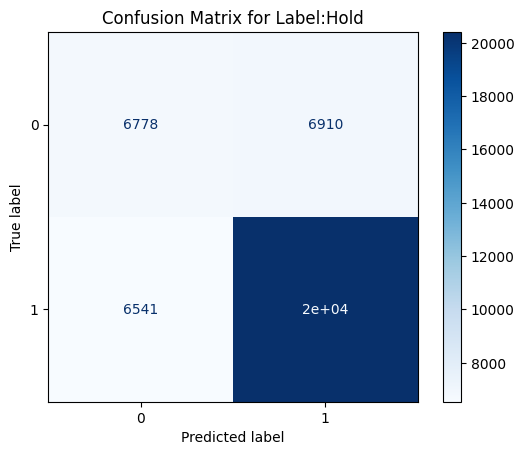

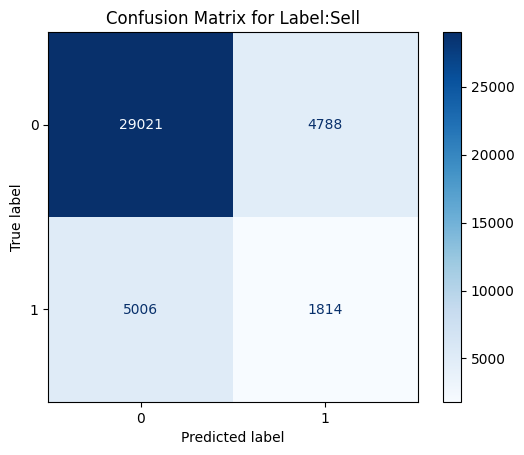

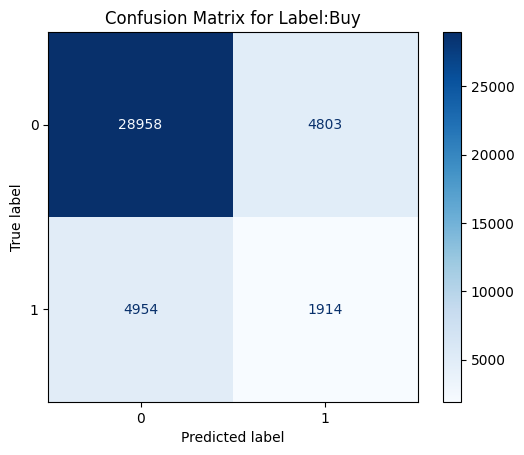

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
cm = multilabel_confusion_matrix(y_trial, scores)
for i, matrix in enumerate(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap = "Blues")
    plt.title(f"Confusion Matrix for Label:{target_names[i]}"  )
    plt.show()

# WTI min analysis

### Read the data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TESI/csv data/commodity/DCOILWTICO.csv")

In [ ]:
data

DATE DCOILWTICO
0     2000-01-04      25.56
1     2000-01-05      24.65
2     2000-01-06      24.79
3     2000-01-07      24.79
4     2000-01-10      24.71
...          ...        ...
6140  2023-07-18      75.76
6141  2023-07-19       75.4
6142  2023-07-20      75.65
6143  2023-07-21      77.06
6144  2023-07-24      78.81

[6145 rows x 2 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        6145 non-null   object
 1   DCOILWTICO  6145 non-null   object
dtypes: object(2)
memory usage: 96.1+ KB


###Data Preprocessing

In [ ]:
data["Date"] = new_date(data["DATE"])
data["DCOILWTICO"].replace(".", None, inplace=True)
data["Close"] = obj_to_float2(data["DCOILWTICO"])

<ipython-input-5-3ebdce88bdc5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col.iloc[idx] = float_value


In [ ]:
#data["Close"] = data["Close"].replace(data["Close"].min(), 0.0)

In [ ]:
data["Close"].describe()

count    6145.000000
mean       62.808668
std        25.920793
min       -36.980000
25%        41.940000
50%        60.370000
75%        82.510000
max       145.310000
Name: Close, dtype: float64

In [ ]:
data

DATE DCOILWTICO       Date  Close
0     2000-01-04      25.56 2000-01-04  25.56
1     2000-01-05      24.65 2000-01-05  24.65
2     2000-01-06      24.79 2000-01-06  24.79
3     2000-01-07      24.79 2000-01-07  24.79
4     2000-01-10      24.71 2000-01-10  24.71
...          ...        ...        ...    ...
6140  2023-07-18      75.76 2023-07-18  75.76
6141  2023-07-19       75.4 2023-07-19  75.40
6142  2023-07-20      75.65 2023-07-20  75.65
6143  2023-07-21      77.06 2023-07-21  77.06
6144  2023-07-24      78.81 2023-07-24  78.81

[6145 rows x 4 columns]

In [ ]:
data["Net"] = data["Close"].diff()

In [ ]:
data['Close'].fillna(method='ffill', inplace=True)
data['Net'].fillna(method='ffill', inplace=True)

In [ ]:
data["Net"].fillna(0.0, inplace = True)

In [ ]:
data = data.drop(["DATE", "DCOILWTICO"], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6145 non-null   datetime64[ns]
 1   Close   6145 non-null   float64       
 2   Net     6145 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 144.1 KB


#### Feature Engineering

In [ ]:
period = 14
# moving average
data['MA'] = data['Close'].copy().rolling(window=period).mean()

# Calculate standard deviation
data['std_dev'] = data['Close'].copy().rolling(window=period).std()

# exponential moving average
data["EMA"] = calculate_ema(data,period)
# residual strength index
data["RSI"] = calculate_rsi(data,period)
data.fillna(data.mean(), inplace = True)
data['SMA_Net'] = data['Net'].rolling(window=14).mean()
data['EMA_Net'] = data['Net'].ewm(span=14, adjust=False).mean()
data['std_dev_Net'] = data['Net'].rolling(window=14).std()


<ipython-input-33-b3c36fa5771b>:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace = True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6145 non-null   datetime64[ns]
 1   Close        6145 non-null   float64       
 2   Net          6145 non-null   float64       
 3   MA           6145 non-null   float64       
 4   std_dev      6145 non-null   float64       
 5   EMA          6145 non-null   float64       
 6   RSI          6145 non-null   float64       
 7   SMA_Net      6132 non-null   float64       
 8   EMA_Net      6145 non-null   float64       
 9   std_dev_Net  6132 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 480.2 KB


In [ ]:
data.dropna(inplace=True)

### Create Target

#### Set the multi-class target. It consists in either a price stays the same (0) or decrease more than 0.5 std (1) or increase more than 0.5 std (2).

In [ ]:
data["Trend"] = build_target(data["Net"])

#### Target

class 0 is weighted 1.0
class 1 is weighted 4.0
class 2 is weighted 4.0


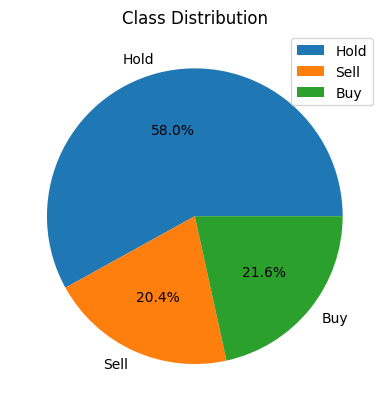

In [ ]:
tgt = data["Trend"]
grows, decrease, same = 0,0,0
for value in tgt:
  if value == 2:
    grows += 1
  elif value == 1:
    decrease += 1
  else:
    same += 1
class_labels = ["Hold",'Sell', 'Buy']
plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
plt.title("Class Distribution")
plt.legend()
n = len(tgt)
class_distr = [same/n, decrease/n, grows/n]
weight_tensor = loss_weights(class_distr)
for i , val in enumerate(weight_tensor.numpy()) :
  print("class",i,"is weighted",val)

### Some Visualizations

In [ ]:
df = data.rename(columns  = {"Trend" : "Investment Decision"})
correlation_matrix = df.corr()
correlation_matrix

<ipython-input-101-427f818c3f4e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Close       Net        MA   std_dev       EMA  \
Close                1.000000  0.027668  0.993537  0.359184  0.995200   
Net                  0.027668  1.000000 -0.023589 -0.040465 -0.021312   
MA                   0.993537 -0.023589  1.000000  0.381916  0.999674   
std_dev              0.359184 -0.040465  0.381916  1.000000  0.381177   
EMA                  0.995200 -0.021312  0.999674  0.381177  1.000000   
RSI                  0.066859  0.225891 -0.017094 -0.149557 -0.006290   
SMA_Net              0.093402  0.272229 -0.002264 -0.225476  0.009593   
EMA_Net              0.096384  0.499515 -0.015163 -0.206610 -0.001480   
std_dev_Net          0.402234 -0.051264  0.422928  0.782322  0.423095   
Investment Decision  0.198562  0.324458  0.186275  0.206870  0.187317   

                          RSI   SMA_Net   EMA_Net  std_dev_Net  \
Close                0.066859  0.093402  0.096384     0.402234   
Net                  0.225891  0.272229  0.499515    -0.051264   
MA                  -0.017094 -0.002264 -0.015163     0.422928   
std_dev             -0.149557 -0.225476 -0.206610     0.782322   
EMA                 -0.006290  0.009593 -0.001480     0.423095   
RSI                  1.000000  0.872501  0.747211    -0.177853   
SMA_Net              0.872501  1.000000  0.856890    -0.211498   
EMA_Net              0.747211  0.856890  1.000000    -0.193056   
std_dev_Net         -0.177853 -0.211498 -0.193056     1.000000   
Investment Decision  0.038055  0.046177  0.123824     0.246793   

                     Investment Decision  
Close                           0.198562  
Net                             0.324458  
MA                              0.186275  
std_dev                         0.206870  
EMA                             0.187317  
RSI                             0.038055  
SMA_Net                         0.046177  
EMA_Net                         0.123824  
std_dev_Net                     0.246793  
Investment Decision             1.000000

<Axes: >

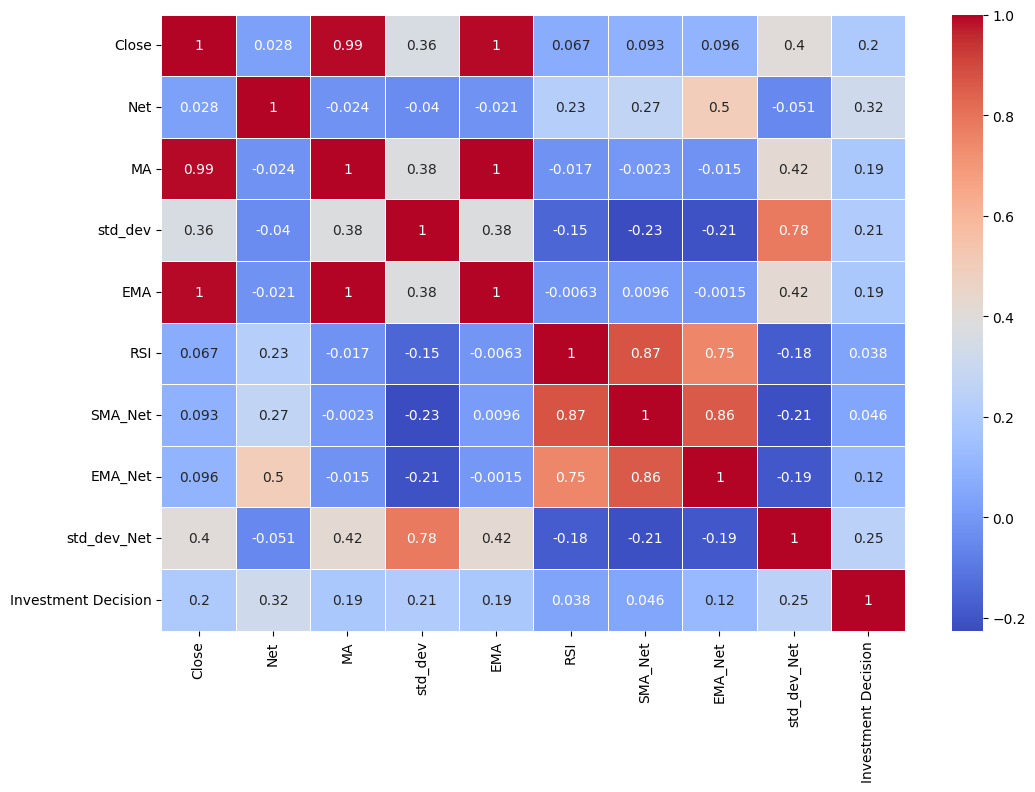

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True ,linewidths=0.5, cmap = "coolwarm")

It is evident how Close, Open, Low, High are actually collinear. Therefore, only one of them can be included in the model to avoid all the multicollinearity issues. For reliability purposes, I stand for choosing "Close". Having noted this, it is also clear that "%Chg" and "Net" are collinear and for the aforementioned reason, I prefer keeping "%Chg". Finally, I have Result which has a high correlation with "%Chg" as it is obtained from it. For this, I keep Result as target variable.

#### Analyse closing prices

In [ ]:
data["Close"].describe()

count    6132.000000
mean       62.891204
std        25.875788
min         0.000000
25%        42.182500
50%        60.422500
75%        82.565000
max       145.310000
Name: Close, dtype: float64

KeyboardInterrupt: ignored

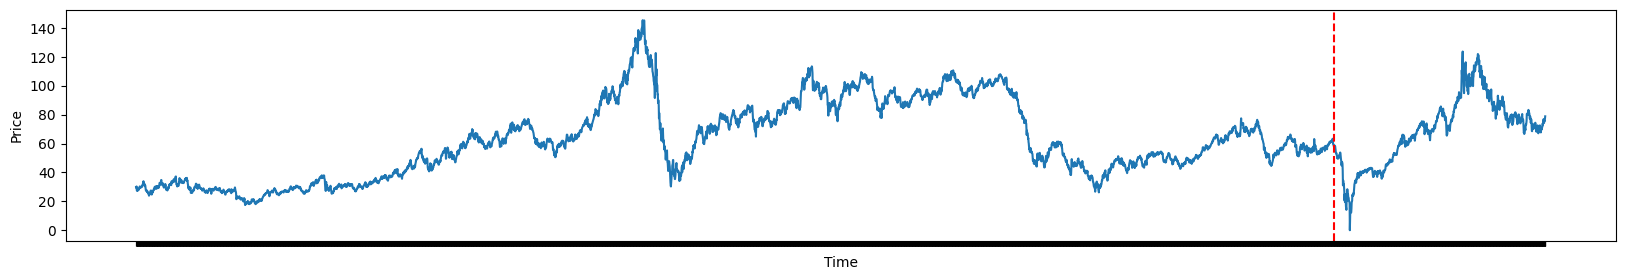

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["Date"].astype(str), data["Close"])
plt.xlabel('Time')
plt.ylabel('Price')

plt.axvline(int(len(data["Date"])*0.85), color='r', linestyle='--', label='Testing data')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.title('WTI Closing Prices per day ')
plt.legend(["Price trend","Testing data"],fontsize="10")

In [ ]:
plt.hist(data["Close"],edgecolor='white', bins = 80)
plt.ylabel("Count")
plt.xlabel("Price")
plt.title("Count of closing price values")

Clearly not normally distributed, they need normalization(applied after splitting training-validation-test sets).

#### New Features

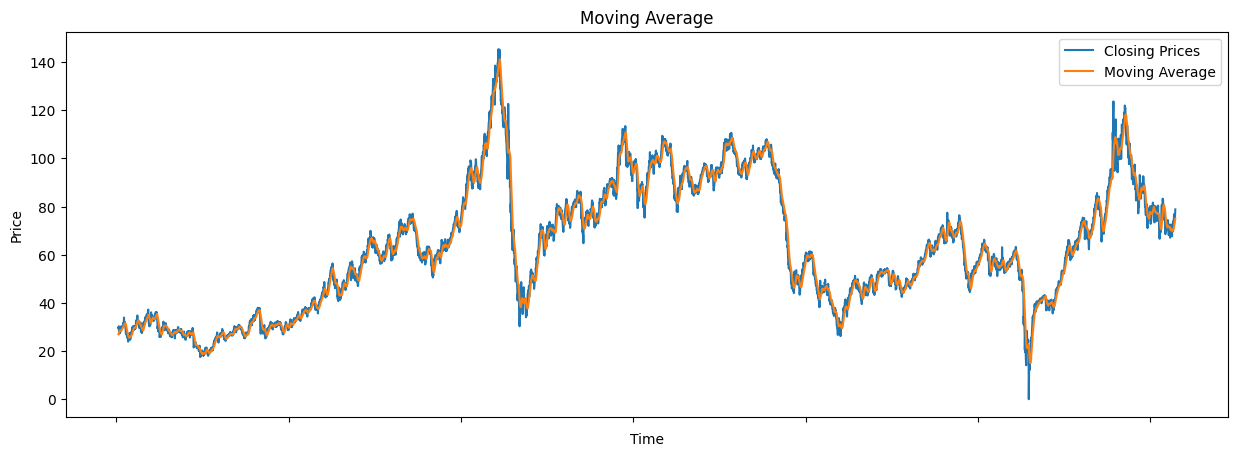

In [ ]:
##MA
plt.figure(figsize = (15,5))
plt.plot(data["Close"], label='Closing Prices')
plt.plot(data["MA"], label='Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Moving Average')
plt.show()


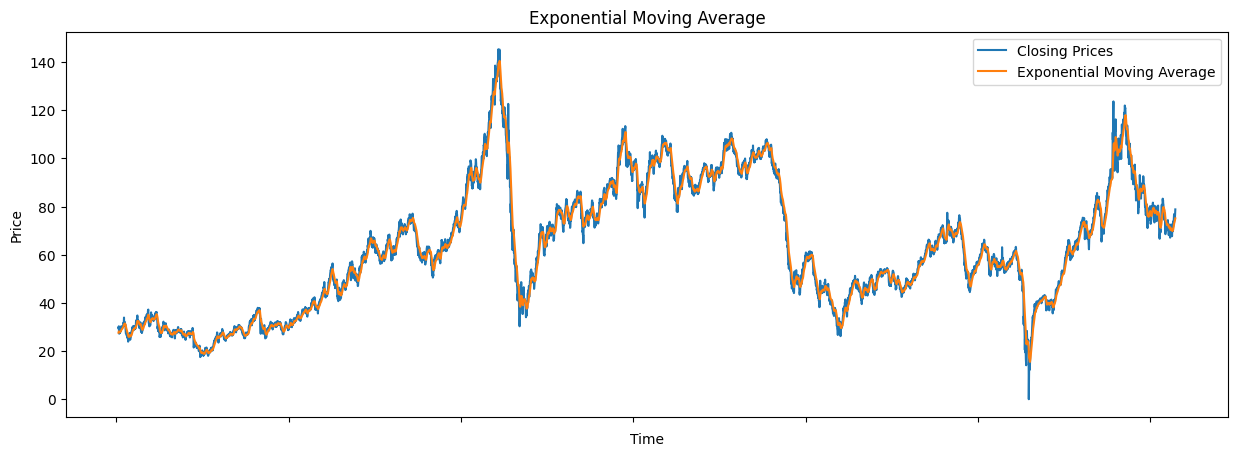

In [ ]:
##EMA
plt.figure(figsize = (15,5))
plt.plot(data["Close"], label='Closing Prices')
plt.plot(data["EMA"], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Exponential Moving Average')
plt.show()


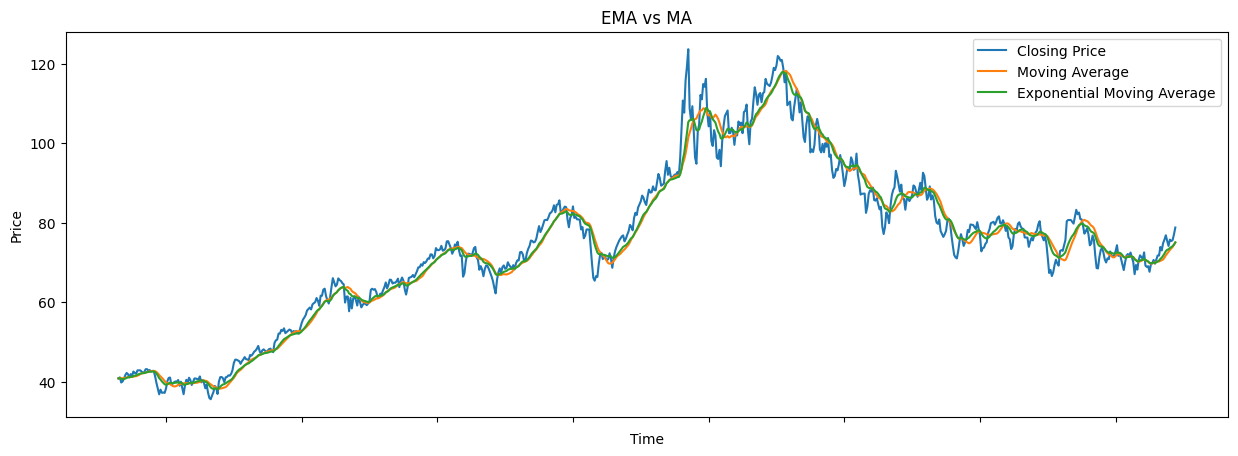

In [ ]:
##EMA vs MS
plt.figure(figsize = (15,5))
plt.plot(data["Close"][-780:], label='Closing Price')
plt.plot(data["MA"][-780:], label='Moving Average')
plt.plot(data["EMA"][-780:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('EMA vs MA')
plt.show()

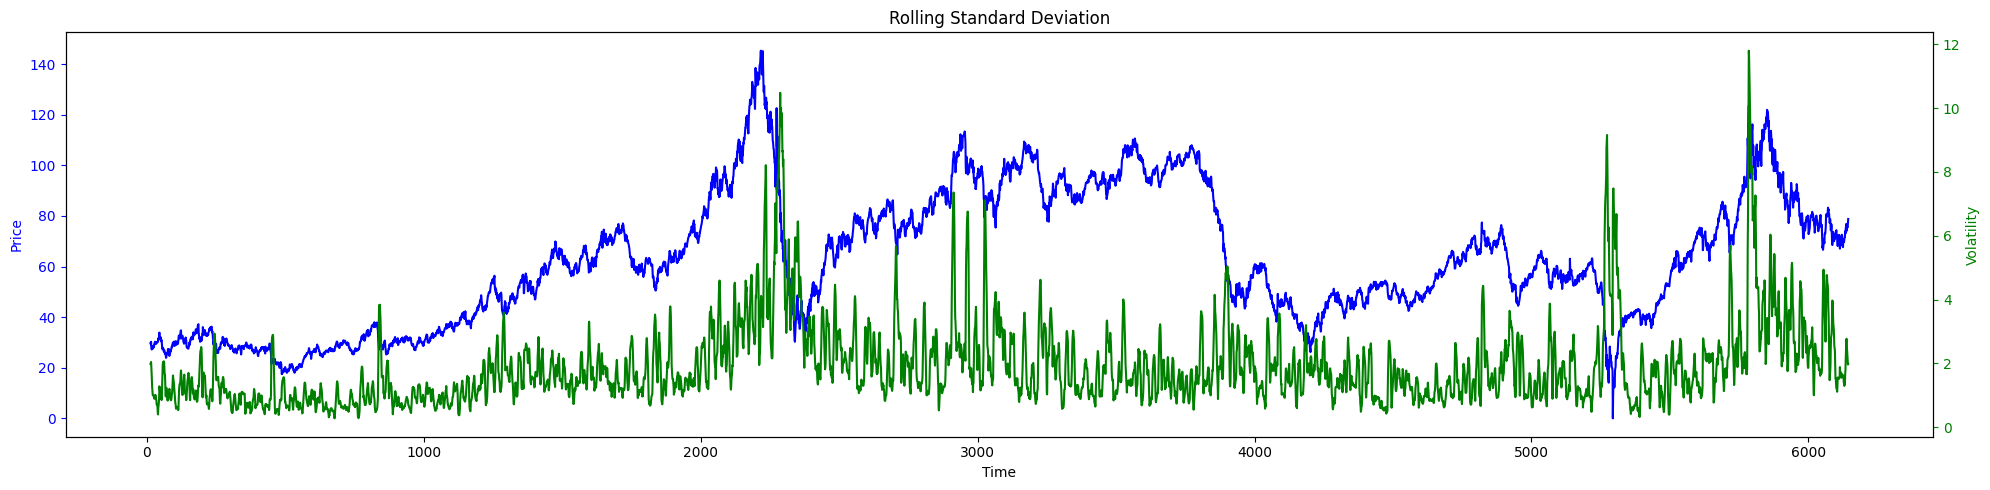

In [ ]:
## STD_DEV
fig, ax1 = plt.subplots(figsize = (20,5))

# Plot the closing prices on the primary y-axis
ax1.plot(data["Close"], label='Closing Prices', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for the rolling standard deviation
ax2 = ax1.twinx()
ax2.plot(data["std_dev"], label='Rolling Standard Deviation', color='g')
ax2.set_ylabel('Volatility', color='g')
ax2.tick_params('y', colors='g')

plt.title('Rolling Standard Deviation')
fig.tight_layout()
plt.show()

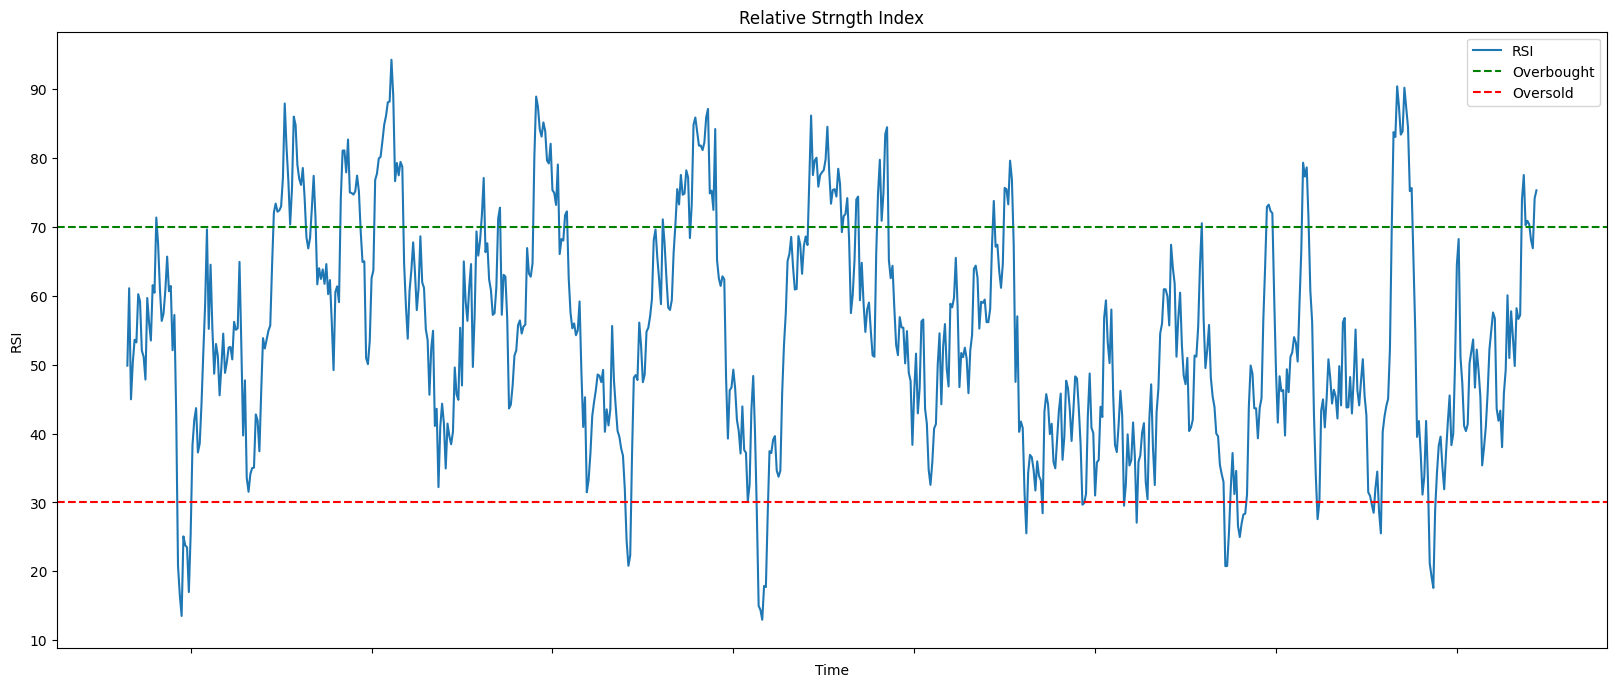

In [ ]:
##RSI
plt.figure(figsize = (20,8))
plt.plot(data["RSI"][-780:], label='RSI') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(70, color='g', linestyle='--', label='Overbought')
plt.axhline(30, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('RSI')
plt.title('Relative Strngth Index')
plt.show()

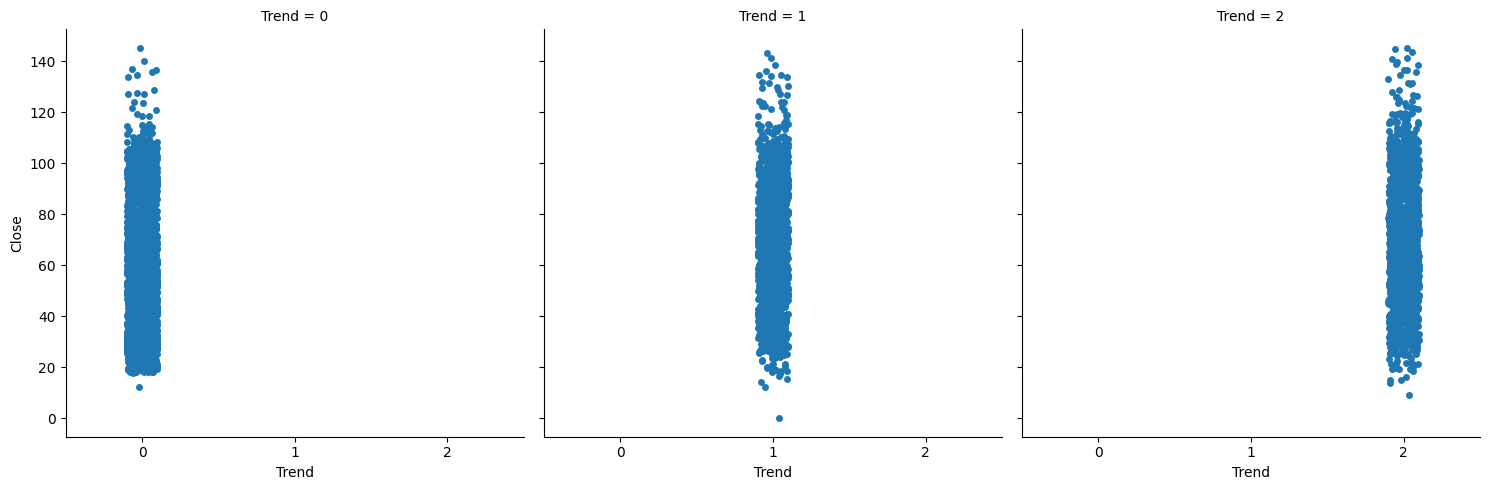

In [ ]:
import seaborn as sns
sns.catplot(x="Trend", y="Close", data=data, col = "Trend")


In [ ]:
data["Close"].describe()

count    6132.000000
mean       62.891204
std        25.875788
min         0.000000
25%        42.182500
50%        60.422500
75%        82.565000
max       145.310000
Name: Close, dtype: float64

### Feature Selection

In [ ]:
correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)

correlations

<ipython-input-38-ce59e57b9ad5>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)


Net            0.269982
std_dev        0.211377
Close          0.208475
std_dev_Net    0.203423
EMA            0.198802
MA             0.197924
EMA_Net        0.106003
SMA_Net        0.040564
RSI            0.035203
dtype: float64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6132 entries, 13 to 6144
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6132 non-null   datetime64[ns]
 1   Close        6132 non-null   float64       
 2   Net          6132 non-null   float64       
 3   MA           6132 non-null   float64       
 4   std_dev      6132 non-null   float64       
 5   EMA          6132 non-null   float64       
 6   RSI          6132 non-null   float64       
 7   SMA_Net      6132 non-null   float64       
 8   EMA_Net      6132 non-null   float64       
 9   std_dev_Net  6132 non-null   float64       
 10  Trend        6132 non-null   int64         
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 574.9 KB


In [ ]:
from sklearn.feature_selection import mutual_info_classif
data = data.drop(['Date'],axis = 1)

X_sample, y_sample = data.iloc[:,:-1],data.iloc[:,-1]
# Calculate mutual information
mi_scores = mutual_info_classif(X_sample, y_sample, random_state = 42)
# Create a dataframe of features and their mutual information scores
mi_scores_df = pd.DataFrame({'Feature': X_sample.columns, 'MI_Score': mi_scores})


In [ ]:
mi_scores_df

Feature  MI_Score
0        Close  0.034387
1          Net  0.970455
2           MA  0.028324
3      std_dev  0.035088
4          EMA  0.024825
5          RSI  0.035145
6      SMA_Net  0.045552
7      EMA_Net  0.105110
8  std_dev_Net  0.080689

In [ ]:
columns = mi_scores_df["Feature"].iloc[np.where(mi_scores_df["MI_Score"] > 0.03)].tolist()
columns.append("Trend")
print(columns)

['Close', 'Net', 'std_dev', 'RSI', 'SMA_Net', 'EMA_Net', 'std_dev_Net', 'Trend']


### Train, Validation and test split

### Keras data

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
X_parent = data[columns]#,"Volume","%Chg","williams_percent_r","MA","EMA","std_dev","RSI"

train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.45)


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns =columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 40)
X_v, y_v = generate_keras_dataset(valid_scaled ,lookback = 40)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 40)

In [ ]:
print("X_Train shape is:", X_tr.shape)
print("y_Train shape is:",  y_tr.shape)
print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (4865, 40, 7)
y_Train shape is: (4865,)
Validation set size is: (512, 40, 7)
Testing set size is: (635, 40, 7)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 3559, 1: 1251, 2: 1322}
Count of classes in the training set {0: 2904, 1: 959, 2: 1002}
Count of classes in the validation set {0: 315, 1: 96, 2: 101}
Count of classes in the test set {0: 254, 1: 180, 2: 201}


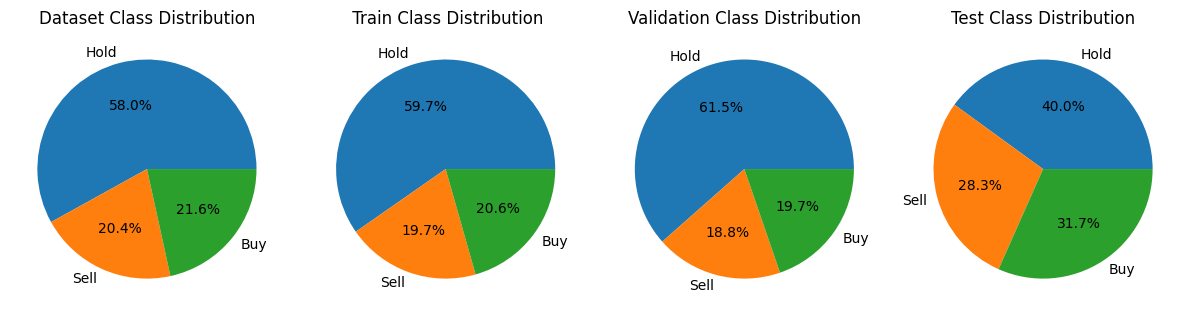

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 4, 1)
plt.pie(class_counts.values(), labels=labels, autopct='%1.1f%%')
plt.title("Dataset Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 4, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title(" Train Class Distribution")

# Plot the second pie chart in the middle subplot
plt.subplot(1, 4, 3)
plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 4, 4)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)

{0: 0.558425160697888, 1: 1.6909975669099757, 2: 1.6184298070525616}


### KERAS TRIAL 2

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

X_parent = data[columns].copy()
#train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.4)
train,  test = train_test_split(X_parent,test_size = 0.2)

X = train[columns[:-1]]  # All rows, all columns except the last one
y = train["Trend"]   # All rows, only the last column (class labels)
unique, counts = np.unique(y, return_counts=True)

initial_train_class = dict(zip(unique, counts))
print("Train class distribution", initial_train_class)



Train class distribution {0: 2842, 1: 1009, 2: 1054}


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
#valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns = columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
#valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 40)
#X_v, y_v = generate_keras_dataset(valid ,lookback = 40)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 40)

In [ ]:
print("X_Train shape is:", X_tr.shape)
#print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (4865, 40, 7)
Testing set size is: (1187, 40, 7)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
#class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
#print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 3559, 1: 1251, 2: 1322}
Count of classes in the training set {0: 2818, 1: 1001, 2: 1046}
Count of classes in the test set {0: 697, 1: 229, 2: 261}


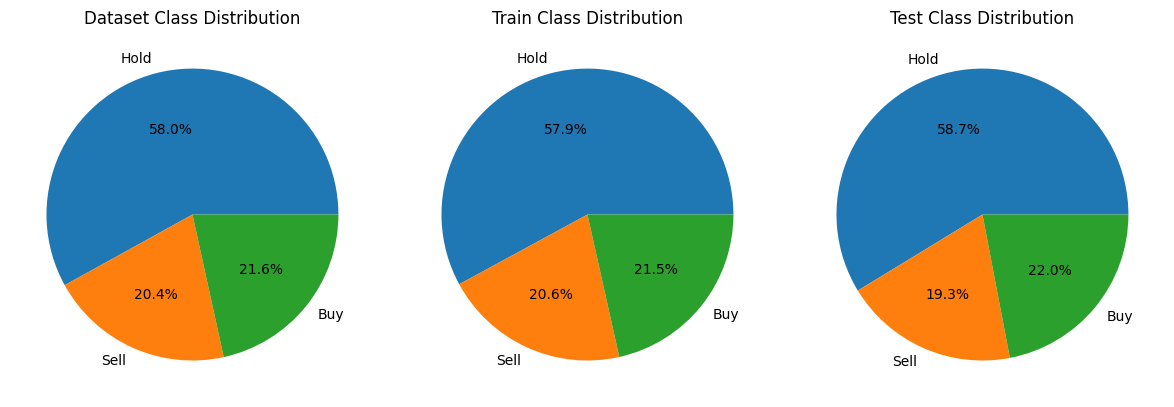

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 3, 1)
plt.pie(class_counts.values(), labels=labels, autopct='%1.1f%%')
plt.title("Dataset Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 3, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title("Train Class Distribution")

# Plot the second pie chart in the middle subplot
#plt.subplot(1, 4, 3)
#plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
#plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 3, 3)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)


{0: 0.5754672344452331, 1: 1.6200466200466201, 2: 1.5503505417463352}


### Baseline LSTM

This is fold n 1
Train class distribution: [694 254 269]
Validation class distribution: [701 248 267]
Class weights {0: 0.5845341018251681, 1: 1.5971128608923884, 2: 1.549371085196313}


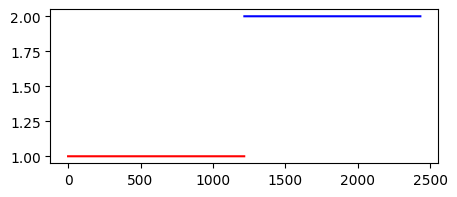

Epoch 1/10
77/77 [==============================] - 27s 94ms/step - loss: 1.1089 - sparse_categorical_accuracy: 0.2276 - val_loss: 1.0998 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/10
77/77 [==============================] - 3s 35ms/step - loss: 1.1087 - sparse_categorical_accuracy: 0.3361 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.2081
Epoch 3/10
77/77 [==============================] - 3s 43ms/step - loss: 1.1089 - sparse_categorical_accuracy: 0.2662 - val_loss: 1.1006 - val_sparse_categorical_accuracy: 0.2081
Epoch 4/10
77/77 [==============================] - 4s 47ms/step - loss: 1.1089 - sparse_categorical_accuracy: 0.2769 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.3224
Epoch 5/10
77/77 [==============================] - 4s 49ms/step - loss: 1.1084 - sparse_categorical_accuracy: 0.3295 - val_loss: 1.1040 - val_sparse_categorical_accuracy: 0.2130
Epoch 6/10
77/77 [==============================] - 3s 36ms/step - loss: 1.1080 - sparse_categorical_acc

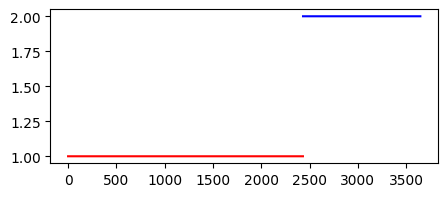

Epoch 1/10
153/153 [==============================] - 5s 34ms/step - loss: 1.1084 - sparse_categorical_accuracy: 0.2992 - val_loss: 1.1049 - val_sparse_categorical_accuracy: 0.2812
Epoch 2/10
153/153 [==============================] - 6s 37ms/step - loss: 1.1079 - sparse_categorical_accuracy: 0.3905 - val_loss: 1.0984 - val_sparse_categorical_accuracy: 0.3734
Epoch 3/10
153/153 [==============================] - 5s 35ms/step - loss: 1.1081 - sparse_categorical_accuracy: 0.3592 - val_loss: 1.1041 - val_sparse_categorical_accuracy: 0.3684
Epoch 4/10
153/153 [==============================] - 6s 39ms/step - loss: 1.1069 - sparse_categorical_accuracy: 0.3839 - val_loss: 1.1121 - val_sparse_categorical_accuracy: 0.3421
Epoch 5/10
153/153 [==============================] - 5s 32ms/step - loss: 1.1067 - sparse_categorical_accuracy: 0.3473 - val_loss: 1.0927 - val_sparse_categorical_accuracy: 0.5296
Epoch 6/10
153/153 [==============================] - 5s 36ms/step - loss: 1.1070 - sparse_cate

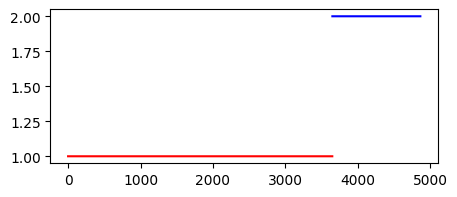

Epoch 1/10
229/229 [==============================] - 9s 38ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.4176 - val_loss: 1.0924 - val_sparse_categorical_accuracy: 0.4498
Epoch 2/10
229/229 [==============================] - 7s 31ms/step - loss: 1.1064 - sparse_categorical_accuracy: 0.3891 - val_loss: 1.0933 - val_sparse_categorical_accuracy: 0.4211
Epoch 3/10
229/229 [==============================] - 8s 36ms/step - loss: 1.1050 - sparse_categorical_accuracy: 0.3450 - val_loss: 1.1099 - val_sparse_categorical_accuracy: 0.4153
Epoch 4/10
229/229 [==============================] - 7s 30ms/step - loss: 1.1050 - sparse_categorical_accuracy: 0.4711 - val_loss: 1.0861 - val_sparse_categorical_accuracy: 0.5222
Epoch 5/10
229/229 [==============================] - 9s 39ms/step - loss: 1.1060 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.0904 - val_sparse_categorical_accuracy: 0.4663
Epoch 6/10
229/229 [==============================] - 8s 33ms/step - loss: 1.1051 - sparse_cate

In [ ]:
# Specify the number of folds
k = 3
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.01
num_layers= 10
l2_rate = 0.0
lr = 1e-4
opt = keras.optimizers.Adam(learning_rate= lr)
keras_lstm = create_keras_model(inp_size=inp_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
keras_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (2.92 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    keras_lstm.fit(X_train, y_train,epochs=10, batch_size=16, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  keras_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))

### AttentionLSTM

This is fold n 1
Train class distribution: [694 254 269]
Validation class distribution: [701 248 267]
Class weights {0: 0.5845341018251681, 1: 1.5971128608923884, 2: 1.5080545229244113}


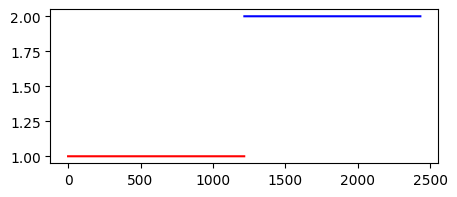

Epoch 1/10
77/77 [==============================] - 64s 212ms/step - loss: 1.0987 - sparse_categorical_accuracy: 0.4873 - val_loss: 1.0968 - val_sparse_categorical_accuracy: 0.4490
Epoch 2/10
77/77 [==============================] - 7s 90ms/step - loss: 1.0984 - sparse_categorical_accuracy: 0.4749 - val_loss: 1.0971 - val_sparse_categorical_accuracy: 0.4013
Epoch 3/10
77/77 [==============================] - 5s 64ms/step - loss: 1.0980 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.3100
Epoch 4/10
77/77 [==============================] - 6s 80ms/step - loss: 1.0977 - sparse_categorical_accuracy: 0.3394 - val_loss: 1.0976 - val_sparse_categorical_accuracy: 0.3141
Epoch 5/10
77/77 [==============================] - 5s 71ms/step - loss: 1.0971 - sparse_categorical_accuracy: 0.3007 - val_loss: 1.0979 - val_sparse_categorical_accuracy: 0.2673
Epoch 6/10
77/77 [==============================] - 5s 64ms/step - loss: 1.0963 - sparse_categorical_ac

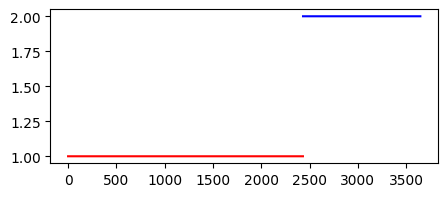

Epoch 1/10
153/153 [==============================] - 9s 57ms/step - loss: 1.0982 - sparse_categorical_accuracy: 0.2754 - val_loss: 1.0995 - val_sparse_categorical_accuracy: 0.2615
Epoch 2/10
153/153 [==============================] - 10s 64ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.2873 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.2862
Epoch 3/10
153/153 [==============================] - 10s 65ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.2877 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.2854
Epoch 4/10
153/153 [==============================] - 10s 65ms/step - loss: 1.0960 - sparse_categorical_accuracy: 0.3194 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.3133
Epoch 5/10
153/153 [==============================] - 10s 66ms/step - loss: 1.0958 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/10
153/153 [==============================] - 10s 64ms/step - loss: 1.0951 - sparse

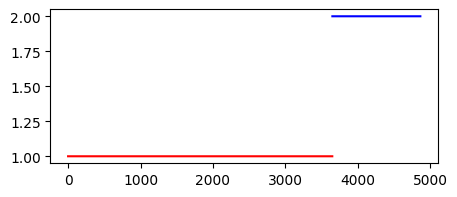

Epoch 1/10
229/229 [==============================] - 14s 59ms/step - loss: 1.0961 - sparse_categorical_accuracy: 0.3579 - val_loss: 1.0893 - val_sparse_categorical_accuracy: 0.4112
Epoch 2/10
229/229 [==============================] - 14s 60ms/step - loss: 1.0949 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.1003 - val_sparse_categorical_accuracy: 0.3446
Epoch 3/10
229/229 [==============================] - 15s 64ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.3461 - val_loss: 1.0922 - val_sparse_categorical_accuracy: 0.3914
Epoch 4/10
229/229 [==============================] - 13s 59ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.4050 - val_loss: 1.1026 - val_sparse_categorical_accuracy: 0.3618
Epoch 5/10
229/229 [==============================] - 14s 60ms/step - loss: 1.0937 - sparse_categorical_accuracy: 0.3659 - val_loss: 1.0897 - val_sparse_categorical_accuracy: 0.4104
Epoch 6/10
229/229 [==============================] - 15s 65ms/step - loss: 1.0931 - spars

In [ ]:
# Specify the number of folds
k = 3
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.01
num_layers= 10
l2_rate = 0.0
lr = 1e-5


opt = keras.optimizers.Adam(learning_rate= lr)
att_lstm = build_attention_model(input_shape=X_tr.shape[1:], hidden_size=hidden_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
att_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    att_lstm.fit(X_train, y_train,epochs=10, batch_size=16, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  att_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


#### BEST

This is fold n 1
Train class distribution: [924 333 366]
Validation class distribution: [952 335 334]
Class weights {0: 0.5854978354978355, 1: 1.6246246246246245, 2: 1.4781420765027322}


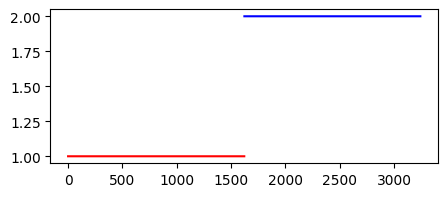

Epoch 1/10
51/51 [==============================] - 58s 209ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.2495 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.2412
Epoch 2/10
51/51 [==============================] - 4s 79ms/step - loss: 1.0982 - sparse_categorical_accuracy: 0.3068 - val_loss: 1.1021 - val_sparse_categorical_accuracy: 0.2505
Epoch 3/10
51/51 [==============================] - 4s 71ms/step - loss: 1.0958 - sparse_categorical_accuracy: 0.3112 - val_loss: 1.1011 - val_sparse_categorical_accuracy: 0.3171
Epoch 4/10
51/51 [==============================] - 3s 64ms/step - loss: 1.0941 - sparse_categorical_accuracy: 0.3506 - val_loss: 1.0962 - val_sparse_categorical_accuracy: 0.2998
Epoch 5/10
51/51 [==============================] - 5s 93ms/step - loss: 1.0903 - sparse_categorical_accuracy: 0.3173 - val_loss: 1.0973 - val_sparse_categorical_accuracy: 0.3122
Epoch 6/10
51/51 [==============================] - 3s 64ms/step - loss: 1.0889 - sparse_categorical_ac

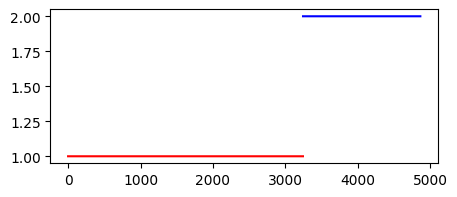

Epoch 1/10
102/102 [==============================] - 7s 66ms/step - loss: 1.0941 - sparse_categorical_accuracy: 0.3696 - val_loss: 1.1053 - val_sparse_categorical_accuracy: 0.3165
Epoch 2/10
102/102 [==============================] - 6s 56ms/step - loss: 1.0925 - sparse_categorical_accuracy: 0.3379 - val_loss: 1.0942 - val_sparse_categorical_accuracy: 0.3911
Epoch 3/10
102/102 [==============================] - 8s 76ms/step - loss: 1.0906 - sparse_categorical_accuracy: 0.3690 - val_loss: 1.0978 - val_sparse_categorical_accuracy: 0.3942
Epoch 4/10
102/102 [==============================] - 6s 55ms/step - loss: 1.0906 - sparse_categorical_accuracy: 0.3819 - val_loss: 1.1028 - val_sparse_categorical_accuracy: 0.3572
Epoch 5/10
102/102 [==============================] - 6s 58ms/step - loss: 1.0882 - sparse_categorical_accuracy: 0.3329 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.3510
Epoch 6/10
102/102 [==============================] - 7s 64ms/step - loss: 1.0878 - sparse_cate

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.05
num_layers= 10
l2_rate = 0.0
lr = 5e-5


opt = keras.optimizers.Adam(learning_rate= lr)
att_lstm = build_attention_model(input_shape=X_tr.shape[1:], hidden_size=hidden_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
att_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    att_lstm.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  att_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### Transformer

This is fold n 1
Train class distribution: [694 254 269]
Validation class distribution: [701 248 267]
Class weights {0: 0.5845341018251681, 1: 1.5971128608923884, 2: 1.5080545229244113}


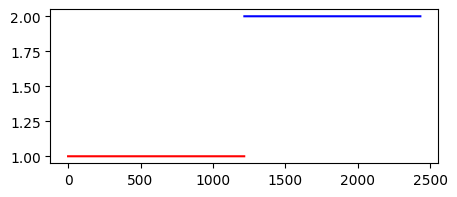

Epoch 1/20
39/39 [==============================] - 17s 53ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.3566 - val_loss: 1.3192 - val_sparse_categorical_accuracy: 0.3191
Epoch 2/20
39/39 [==============================] - 1s 15ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.3541 - val_loss: 1.3142 - val_sparse_categorical_accuracy: 0.3215
Epoch 3/20
39/39 [==============================] - 1s 15ms/step - loss: 1.2451 - sparse_categorical_accuracy: 0.3550 - val_loss: 1.3103 - val_sparse_categorical_accuracy: 0.3191
Epoch 4/20
39/39 [==============================] - 1s 15ms/step - loss: 1.2356 - sparse_categorical_accuracy: 0.3607 - val_loss: 1.3070 - val_sparse_categorical_accuracy: 0.3199
Epoch 5/20
39/39 [==============================] - 1s 15ms/step - loss: 1.2304 - sparse_categorical_accuracy: 0.3624 - val_loss: 1.3033 - val_sparse_categorical_accuracy: 0.3199
Epoch 6/20
39/39 [==============================] - 1s 15ms/step - loss: 1.2295 - sparse_categorical_acc

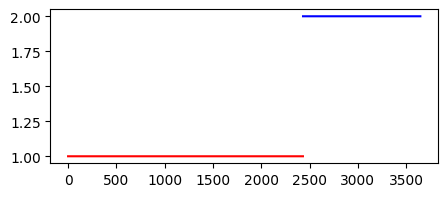

Epoch 1/20
77/77 [==============================] - 1s 13ms/step - loss: 1.2350 - sparse_categorical_accuracy: 0.3420 - val_loss: 1.2196 - val_sparse_categorical_accuracy: 0.3396
Epoch 2/20
77/77 [==============================] - 1s 13ms/step - loss: 1.2295 - sparse_categorical_accuracy: 0.3346 - val_loss: 1.2157 - val_sparse_categorical_accuracy: 0.3396
Epoch 3/20
77/77 [==============================] - 1s 13ms/step - loss: 1.2296 - sparse_categorical_accuracy: 0.3436 - val_loss: 1.2131 - val_sparse_categorical_accuracy: 0.3372
Epoch 4/20
77/77 [==============================] - 1s 12ms/step - loss: 1.2257 - sparse_categorical_accuracy: 0.3350 - val_loss: 1.2104 - val_sparse_categorical_accuracy: 0.3388
Epoch 5/20
77/77 [==============================] - 1s 13ms/step - loss: 1.2195 - sparse_categorical_accuracy: 0.3420 - val_loss: 1.2079 - val_sparse_categorical_accuracy: 0.3413
Epoch 6/20
77/77 [==============================] - 1s 15ms/step - loss: 1.2174 - sparse_categorical_accu

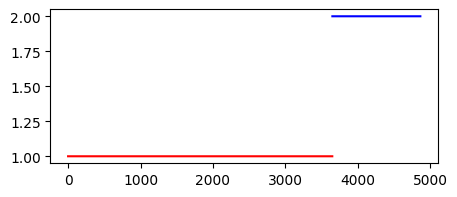

Epoch 1/20
115/115 [==============================] - 2s 14ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.3461 - val_loss: 1.1845 - val_sparse_categorical_accuracy: 0.3520
Epoch 2/20
115/115 [==============================] - 1s 12ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.3486 - val_loss: 1.1828 - val_sparse_categorical_accuracy: 0.3528
Epoch 3/20
115/115 [==============================] - 1s 12ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.3431 - val_loss: 1.1808 - val_sparse_categorical_accuracy: 0.3528
Epoch 4/20
115/115 [==============================] - 1s 12ms/step - loss: 1.1851 - sparse_categorical_accuracy: 0.3461 - val_loss: 1.1793 - val_sparse_categorical_accuracy: 0.3512
Epoch 5/20
115/115 [==============================] - 1s 12ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.3500 - val_loss: 1.1781 - val_sparse_categorical_accuracy: 0.3479
Epoch 6/20
115/115 [==============================] - 1s 13ms/step - loss: 1.1817 - sparse_cate

In [ ]:
# Specify the number of folds
k = 3
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define the Transformer model
model_transformer = build_model2(
    input_shape = X_tr.shape[1:],
    head_size=3,
    num_heads=2,
    ff_dim=128,
    num_transformer_blocks=2,
    dropout=0.05,
l2_rate = 0.00)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3* np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


This is fold n 1
Train class distribution: [694 254 269]
Validation class distribution: [701 248 267]
Class weights {0: 0.5845341018251681, 1: 1.5971128608923884, 2: 1.5080545229244113}


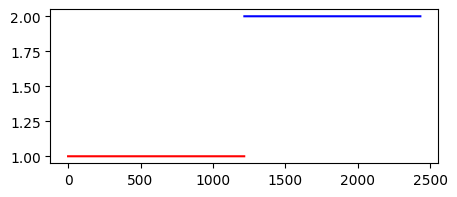

Epoch 1/20
39/39 [==============================] - 19s 38ms/step - loss: 1.2537 - sparse_categorical_accuracy: 0.3254 - val_loss: 1.1897 - val_sparse_categorical_accuracy: 0.3339
Epoch 2/20
39/39 [==============================] - 1s 26ms/step - loss: 1.2357 - sparse_categorical_accuracy: 0.3180 - val_loss: 1.1812 - val_sparse_categorical_accuracy: 0.3331
Epoch 3/20
39/39 [==============================] - 1s 26ms/step - loss: 1.2240 - sparse_categorical_accuracy: 0.3213 - val_loss: 1.1731 - val_sparse_categorical_accuracy: 0.3363
Epoch 4/20
39/39 [==============================] - 1s 22ms/step - loss: 1.2070 - sparse_categorical_accuracy: 0.3246 - val_loss: 1.1681 - val_sparse_categorical_accuracy: 0.3339
Epoch 5/20
39/39 [==============================] - 1s 27ms/step - loss: 1.2067 - sparse_categorical_accuracy: 0.3180 - val_loss: 1.1640 - val_sparse_categorical_accuracy: 0.3355
Epoch 6/20
39/39 [==============================] - 1s 22ms/step - loss: 1.2016 - sparse_categorical_acc

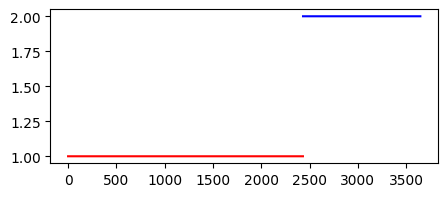

Epoch 1/20
77/77 [==============================] - 1s 12ms/step - loss: 1.1562 - sparse_categorical_accuracy: 0.3494 - val_loss: 1.1294 - val_sparse_categorical_accuracy: 0.3150
Epoch 2/20
77/77 [==============================] - 1s 13ms/step - loss: 1.1514 - sparse_categorical_accuracy: 0.3617 - val_loss: 1.1278 - val_sparse_categorical_accuracy: 0.3199
Epoch 3/20
77/77 [==============================] - 1s 13ms/step - loss: 1.1506 - sparse_categorical_accuracy: 0.3572 - val_loss: 1.1258 - val_sparse_categorical_accuracy: 0.3240
Epoch 4/20
77/77 [==============================] - 1s 13ms/step - loss: 1.1492 - sparse_categorical_accuracy: 0.3605 - val_loss: 1.1249 - val_sparse_categorical_accuracy: 0.3224
Epoch 5/20
77/77 [==============================] - 1s 16ms/step - loss: 1.1497 - sparse_categorical_accuracy: 0.3539 - val_loss: 1.1229 - val_sparse_categorical_accuracy: 0.3298
Epoch 6/20
77/77 [==============================] - 1s 17ms/step - loss: 1.1495 - sparse_categorical_accu

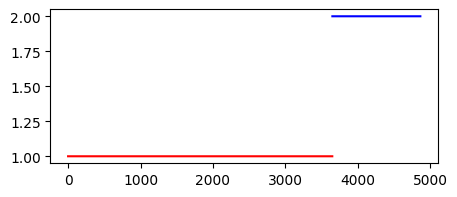

Epoch 1/20
115/115 [==============================] - 3s 27ms/step - loss: 1.1270 - sparse_categorical_accuracy: 0.3426 - val_loss: 1.1268 - val_sparse_categorical_accuracy: 0.3306
Epoch 2/20
115/115 [==============================] - 3s 26ms/step - loss: 1.1268 - sparse_categorical_accuracy: 0.3601 - val_loss: 1.1270 - val_sparse_categorical_accuracy: 0.3289
Epoch 3/20
115/115 [==============================] - 3s 22ms/step - loss: 1.1253 - sparse_categorical_accuracy: 0.3557 - val_loss: 1.1261 - val_sparse_categorical_accuracy: 0.3322
Epoch 4/20
115/115 [==============================] - 3s 23ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.3298
Epoch 5/20
115/115 [==============================] - 2s 19ms/step - loss: 1.1244 - sparse_categorical_accuracy: 0.3489 - val_loss: 1.1250 - val_sparse_categorical_accuracy: 0.3257
Epoch 6/20
115/115 [==============================] - 2s 17ms/step - loss: 1.1187 - sparse_cate

In [ ]:
# Specify the number of folds
k = 3
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=3,
    num_heads=2,
    ff_dim=32,
    num_transformer_blocks=2,
    mlp_units=[32],
    mlp_dropout=0.1,
    dropout=0.05,
l2_rate = 0.00)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3* np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=20, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


#### best

This is fold n 1
Train class distribution: [694 254 269]
Validation class distribution: [701 248 267]
Class weights {0: 0.5845341018251681, 1: 1.5971128608923884, 2: 1.5080545229244113}


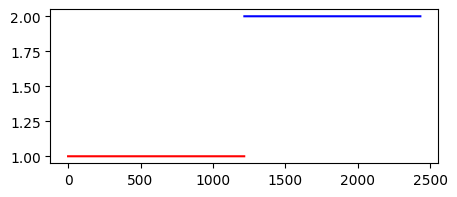

Epoch 1/20
39/39 [==============================] - 20s 35ms/step - loss: 1.2291 - sparse_categorical_accuracy: 0.3435 - val_loss: 1.1555 - val_sparse_categorical_accuracy: 0.3577
Epoch 2/20
39/39 [==============================] - 1s 23ms/step - loss: 1.1670 - sparse_categorical_accuracy: 0.3394 - val_loss: 1.1381 - val_sparse_categorical_accuracy: 0.3528
Epoch 3/20
39/39 [==============================] - 1s 23ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.3385 - val_loss: 1.1238 - val_sparse_categorical_accuracy: 0.3668
Epoch 4/20
39/39 [==============================] - 1s 23ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.3640 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.3470
Epoch 5/20
39/39 [==============================] - 1s 25ms/step - loss: 1.1168 - sparse_categorical_accuracy: 0.3648 - val_loss: 1.1216 - val_sparse_categorical_accuracy: 0.3528
Epoch 6/20
39/39 [==============================] - 1s 25ms/step - loss: 1.0977 - sparse_categorical_acc

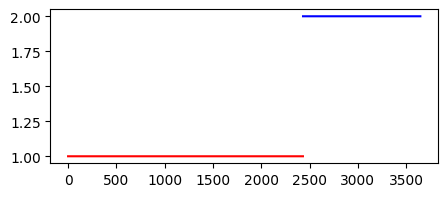

Epoch 1/20
77/77 [==============================] - 2s 31ms/step - loss: 1.0646 - sparse_categorical_accuracy: 0.4287 - val_loss: 1.1273 - val_sparse_categorical_accuracy: 0.3240
Epoch 2/20
77/77 [==============================] - 2s 30ms/step - loss: 1.0609 - sparse_categorical_accuracy: 0.3868 - val_loss: 1.1148 - val_sparse_categorical_accuracy: 0.3536
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 1.0474 - sparse_categorical_accuracy: 0.4513 - val_loss: 1.1207 - val_sparse_categorical_accuracy: 0.3339
Epoch 4/20
77/77 [==============================] - 2s 21ms/step - loss: 1.0544 - sparse_categorical_accuracy: 0.3966 - val_loss: 1.1297 - val_sparse_categorical_accuracy: 0.3191
Epoch 5/20
77/77 [==============================] - 2s 21ms/step - loss: 1.0288 - sparse_categorical_accuracy: 0.4377 - val_loss: 1.1048 - val_sparse_categorical_accuracy: 0.3692
Epoch 6/20
77/77 [==============================] - 2s 21ms/step - loss: 1.0288 - sparse_categorical_accu

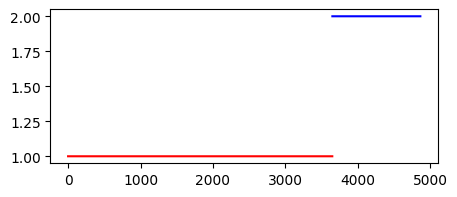

Epoch 1/20
115/115 [==============================] - 2s 20ms/step - loss: 1.0370 - sparse_categorical_accuracy: 0.4212 - val_loss: 1.1093 - val_sparse_categorical_accuracy: 0.3635
Epoch 2/20
115/115 [==============================] - 2s 20ms/step - loss: 1.0200 - sparse_categorical_accuracy: 0.4505 - val_loss: 1.1286 - val_sparse_categorical_accuracy: 0.3224
Epoch 3/20
115/115 [==============================] - 3s 30ms/step - loss: 1.0190 - sparse_categorical_accuracy: 0.4335 - val_loss: 1.1321 - val_sparse_categorical_accuracy: 0.3405
Epoch 4/20
115/115 [==============================] - 2s 21ms/step - loss: 1.0066 - sparse_categorical_accuracy: 0.4385 - val_loss: 1.1161 - val_sparse_categorical_accuracy: 0.3421
Epoch 5/20
115/115 [==============================] - 2s 19ms/step - loss: 0.9987 - sparse_categorical_accuracy: 0.4464 - val_loss: 1.1255 - val_sparse_categorical_accuracy: 0.3421
Epoch 6/20
115/115 [==============================] - 2s 20ms/step - loss: 0.9921 - sparse_cate

In [ ]:
# Specify the number of folds
k = 3
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=8,
    num_heads=8,
    ff_dim=32,
    num_transformer_blocks=4,
    mlp_units=[32],
    mlp_dropout=0.1,
    dropout=0.01,
l2_rate = 0.0)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=20, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### Random Forest Classifier

Train class distribution: [924 333 366]
Validation class distribution: [952 335 334]
Class weights {0: 0.5854978354978355, 1: 1.6246246246246245, 2: 1.4781420765027322}


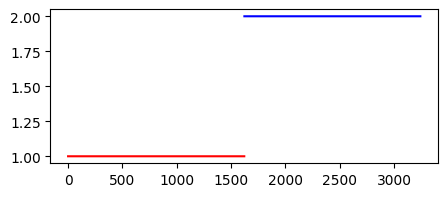

Train class distribution: [1876  668  700]
Validation class distribution: [942 333 346]
Class weights {0: 0.5764036958066808, 1: 1.6187624750499001, 2: 1.5447619047619048}


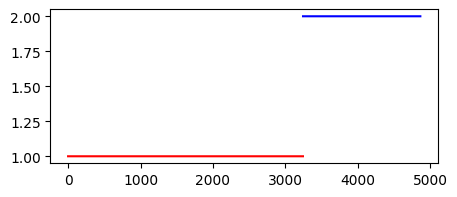

              precision    recall  f1-score   support

        Hold       0.60      0.50      0.54       697
        Sell       0.18      0.21      0.19       229
         Buy       0.23      0.29      0.25       261

    accuracy                           0.40      1187
   macro avg       0.33      0.33      0.33      1187
weighted avg       0.44      0.40      0.41      1187



In [ ]:
n_splits = 2
tscv = TimeSeriesSplit(n_splits=n_splits)
X_flattened = X_tr.reshape(X_tr.shape[0], -1)
X_te_flattened = X_te.reshape(X_te.shape[0], -1)

for train_index, test_index in tscv.split(X_flattened):
    X_train, X_test = X_flattened[train_index], X_flattened[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
        #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state=42,class_weight = class_w)  # Add any hyperparameters you need

    clf.fit(X_train, y_train)

    # Predict on the test set
y_pred = clf.predict(X_te_flattened)
#y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
#print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))
print(classification_report(y_te, y_pred, target_names=target_names,zero_division = 1))


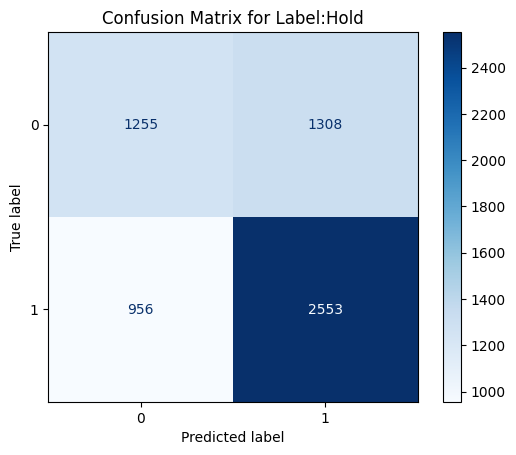

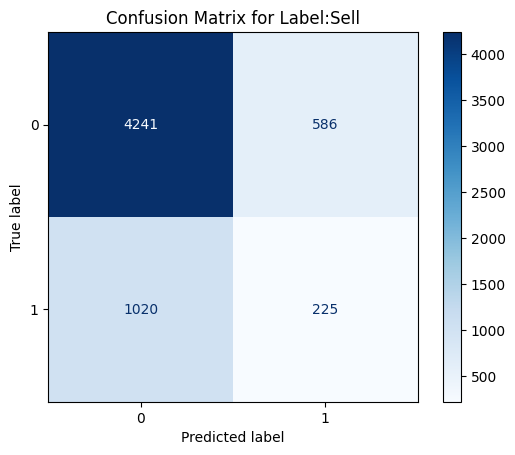

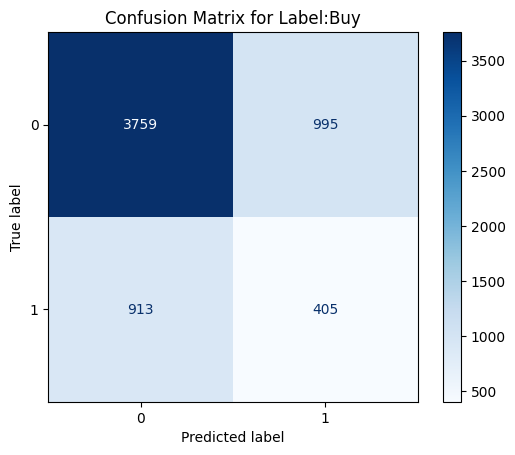

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
cm = multilabel_confusion_matrix(y_trial, scores)
for i, matrix in enumerate(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap = "Blues")
    plt.title(f"Confusion Matrix for Label:{target_names[i]}"  )
    plt.show()

In [ ]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)
X_flattened = X_tr.reshape(X_tr.shape[0], -1)
X_te_flattened = X_te.reshape(X_te.shape[0], -1)

for train_index, test_index in tscv.split(X_flattened):
    X_train, X_test = X_flattened[train_index], X_flattened[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
        #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=42,class_weight = class_w)  # Add any hyperparameters you need

    clf.fit(X_train, y_train)

    # Predict on the test set
y_pred = clf.predict(X_te_flattened)
#y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
#print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))
print(classification_report(y_te, y_pred, target_names=target_names,zero_division = 1))
